# CS257 NLP (W'25) Final Project: Alex Fan, Alex Williams, Charlie Carvajal

## Imports/Setup

In [ ]:
import os
from io import open
import numpy as np
import torch
print(torch.__version__)
import math
import torch.nn as nn
import time
from typing import Tuple, List
# from datasets import load_dataset
import random
import nltk
import gensim.downloader
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

2.5.1+cu124


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
from transformers import AutoModel

In [ ]:

# torch.manual_seed(SEED)
# set device as GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from google.colab import drive


drive.mount('/content/drive')


%cd /content/drive/MyDrive/CS257/coins

# %cd /content/drive/MyDrive/NLP Dumbass Shit/coins


!ls


Mounted at /content/drive
/content/drive/MyDrive/CS257/coins
ANUBIS_tweets.json   ETH_tweets.json   MAP_tweets.json	 PNUT_tweets.json    WIF_tweets.json
BALD_tweets.json     FART_tweets.json  OC_tweets.json	 SHIB_tweets.json
DEFI100_tweets.json  FOLD_tweets.json  PARA_tweets.json  SPX_tweets.json
DOGE_tweets.json     GIGA_tweets.json  PEPE_tweets.json  THODEX_tweets.json


## Data

In [ ]:
def batchify(filename: str, batch_size: int):
    with open(filename, 'r', encoding='utf-8') as f:
        data = json.load(f)
    if not isinstance(data, list):
        raise ValueError("The JSON file must contain a list of JSON objects.")
    batches = [data[i:i + batch_size] for i in range(0, len(data), batch_size)]
    return batches

scam = ["DEFI100_tweets.json", "ANUBIS_tweets.json", "BALD_tweets.json", "FOLD_tweets.json", "MAP_tweets.json", "OC_tweets.json", "PARA_tweets.json", "PNUT_tweets.json", "THODEX_tweets.json"]
legit = ["DOGE_tweets.json", "FART_tweets.json", "GIGA_tweets.json", "PEPE_tweets.json", "SHIB_tweets.json", "SPX_tweets.json", "WIF_tweets.json"]

## Model

### Embedding Tester

In [ ]:

import torch
from transformers import AutoModel, AutoTokenizer

bertweet = AutoModel.from_pretrained("vinai/bertweet-base")


tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

line = "SC has first two presumptive cases of coronavirus , DHEC confirms HTTPURL via @USER :cry:"
w_emojis = "I think we all know its Doge-chan! UwU; \u4eca\u5e74\u306e\u30b7\u30e3\u30ab\u30b7\u30e3\u30ab\u30dd\u30c6\u30c8\u00ae\u306f\u3053\u306e\u65b9\u304c\u767b\u5834\uff01Y"
wo_emojis = "\"not a memecoin\"  listen.. lean-in guys, you have that whole laser-eyes thing going on.. search your feelings you know it be true.  Bitcoin isn't a memecoin. <url>"

input_ids = torch.tensor([tokenizer.encode(w_emojis)])

with torch.no_grad():
    features = bertweet(input_ids)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [ ]:
features[0].shape

torch.Size([1, 38, 768])

In [ ]:
input_ids.shape[1]

38

In [ ]:
tokenizer.decode(139)

'its'

In [ ]:
import json
def json2text(filename: str):
  res = []
  with open(filename, 'r', encoding='utf-8') as f:
    data = json.load(f)
  for obj in data:
    res.append(obj)
  return res


In [ ]:
class InputFormatter:
    """This turns tweet data into the tokenized versions with the correct tweet lengths"""
    def _padder_slicer(self, json_text):
      same_sized_data = []
      labels = []
      attention_masks = []

      for tweet in json_text:
          encoded = self.tokenizer(tweet['text'], return_tensors="pt")
          input_ids = encoded["input_ids"].to(device)
          label = int(tweet['label'])
          size = input_ids.shape[1]
          attention_mask = torch.ones((1, size), dtype=torch.bool, device=device)

          if size > self.config.block_size:
              input_ids = input_ids[:, :self.config.block_size]
              attention_mask = attention_mask[:, :self.config.block_size]
          elif size < self.config.block_size:
              tlen = self.config.block_size - size
              padding = torch.ones((1, tlen), dtype=input_ids.dtype, device=device)
              input_ids = torch.cat((input_ids, padding), dim=1)
              pad_mask = torch.zeros((1, tlen), dtype=torch.bool, device=device)
              attention_mask = torch.cat((attention_mask, pad_mask), dim=1)

          same_sized_data.append(input_ids)
          labels.append(label)
          attention_masks.append(attention_mask)

      xdata = torch.cat(same_sized_data, dim=0)
      ydata = torch.tensor(labels, device=device)
      attn_masks = torch.cat(attention_masks, dim=0)

      return xdata, ydata, attn_masks



    def __init__(self, config, json_tweets, emb_model_name = "bertweet"):
        self.config = config
        self.tokenizer = None

        if emb_model_name == "bertweet":
            self.tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

        self.xdata = None
        self.ydata = None
        self.attn_masks = None

        self.xdata, self.ydata, self.attn_masks = self._padder_slicer(json_tweets)

        self.batch_data = None

In [ ]:
config_all = SCConfig(200, 0.3, 8, 10, 2)

In [ ]:
#test code for embeddings
#need to update these with drive-mounted locations for it to work
# scam = ["DEFI100_tweets.json", "ANUBIS_tweets.json", "BALD_tweets.json", "FOLD_tweets.json", "MAP_tweets.json", "OC_tweets.json", "PARA_tweets.json", "PNUT_tweets.json", "THODEX_tweets.json"]
# legit = ["DOGE_tweets.json", "FART_tweets.json", "GIGA_tweets.json", "PEPE_tweets.json", "SHIB_tweets.json", "SPX_tweets.json", "WIF_tweets.json"]
config = SCConfig(200, 0.3, 8, 10, 2)
scam = ["DEFI100_tweets.json"]
with open("DEFI100_tweets.json", 'r', encoding='utf-8') as f:
    data = json.load(f)
scam_embeddings = InputFormatter(config, data)
print(scam_embeddings.xdata.shape, scam_embeddings.ydata.shape, scam_embeddings.attn_masks.shape)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


torch.Size([162, 200]) torch.Size([162]) torch.Size([162, 200])


### Model Class

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.self_attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.ff = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(4*d_model, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None, key_padding_mask=None):
        attn_output, _ = self.self_attn(x, x, x, attn_mask=attn_mask,
                                        key_padding_mask=key_padding_mask)
        x = self.norm1(x + self.dropout1(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout2(ff_output))
        return x

In [ ]:
class SCConfig:

    def __init__(self, block_size, drop_rate, nhid, nlayers, decoder_layers, **kwargs):
        self.block_size = block_size
        self.mlp_drop = drop_rate
        self.nhid = nhid
        self.nlayers = nlayers      ## possibly how many layers are in the Transformer layer
        self.decoder_layers = decoder_layers      ## This is
        for k,v in kwargs.items():
            setattr(self, k, v)

class ScamClassifier(nn.Module):
    def __init__(self, config):
        super(ScamClassifier, self).__init__()
        self.embedding = bertweet.embeddings.word_embeddings

        self.decoder = TransformerEncoderBlock(
            d_model=config.nhid,
            nhead=config.nlayers,
            dropout=config.mlp_drop
        )
        self.classifier = nn.Sequential(
            nn.Linear(config.nhid, config.nhid // 2),
            nn.ReLU(),
            nn.Dropout(config.mlp_drop),
            nn.Linear(config.nhid // 2, config.nhid // 4),
            nn.ReLU(),
            nn.Dropout(config.mlp_drop),
            nn.Linear(config.nhid // 4, 1)
        )

    def forward(self, inputs, attention_mask):
        embeds = self.embedding(inputs)
        key_padding_mask = ~attention_mask
        x = self.decoder(embeds, attn_mask=None, key_padding_mask=key_padding_mask)
        x = x.mean(dim=1)
        logits = self.classifier(x)
        return logits

class SCControl(nn.Module):
    def __init__(self, config):
        super(SCControl, self).__init__()
        self.embedding = bertweet.embeddings.word_embeddings

        self.classifier = nn.Sequential(
            nn.Linear(config.nhid, config.nhid // 2),
            nn.ReLU(),
            nn.Dropout(config.mlp_drop),
            nn.Linear(config.nhid // 2, config.nhid // 4),
            nn.ReLU(),
            nn.Dropout(config.mlp_drop),
            nn.Linear(config.nhid // 4, 1)
        )

    def forward(self, inputs):
        embeds = self.embedding(inputs)
        x = embeds.mean(dim=1)
        logits = self.classifier(x)
        return logits

class ScamClassifierMaxPooling(ScamClassifier):
  def __init__(self, config):
    super(ScamClassifierMaxPooling, self).__init__(config)
  def forward(self, inputs, attention_mask):
        embeds = self.embedding(inputs)
        key_padding_mask = ~attention_mask
        x = self.decoder(embeds, attn_mask=None, key_padding_mask=key_padding_mask)
        x, _ = x.max(dim=1)
        logits = self.classifier(x)
        return logits

### Training Scripts

Train on everything, randomly sample from entire dataset for train/test split

In [ ]:
class TrainingConfig:

    def __init__(self, epochs, optimizer, criterion):
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = epochs


# def train_one_epoch(
#     epoch: int,
#     model,
#     train_data,
#     config,
#     # batch_size: int,
#     # bptt: int,
#     clip: float,
#     # log_interval: int
# ) -> float:

In [ ]:
import json

def load_and_label(filenames: List[str], label: int) -> List[dict]:
    """Load tweets from a list of JSON filenames and assign the given label to each tweet.

    Args:
        filenames: List of file paths.
        label: The label to assign (e.g., 1 for scam, 0 for legit).

    Returns:
        A list of tweet dictionaries with the added 'label' key.
    """
    all_tweets = []
    for filename in filenames:
        with open(filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
        for tweet in data:
            tweet['label'] = label
        all_tweets.extend(data)
    return all_tweets

scam_files = ["DEFI100_tweets.json",
              "BALD_tweets.json",
              "ANUBIS_tweets.json",
              "FOLD_tweets.json",
              "MAP_tweets.json",
              "OC_tweets.json",
              "PARA_tweets.json",
              "PNUT_tweets.json",
              "THODEX_tweets.json"]

legit_files = ["DOGE_tweets.json",
               "FART_tweets.json",
               "GIGA_tweets.json",
               "PEPE_tweets.json",
               "SHIB_tweets.json",
               "SPX_tweets.json",
               "WIF_tweets.json"]
torch.cuda.empty_cache()
import gc
gc.collect()
scam_tweets = load_and_label(scam_files, label=1)
legit_tweets = load_and_label(legit_files, label=0)
all_tweets = scam_tweets + legit_tweets
import random
random.shuffle(all_tweets)
split_idx = int(0.8 * len(all_tweets))
train_tweets = all_tweets[:split_idx]
test_tweets = all_tweets[split_idx:]
train_embeddings = InputFormatter(config, train_tweets)
test_embeddings = InputFormatter(config, test_tweets)
print("Train xdata shape:", train_embeddings.xdata.shape)
print("Test xdata shape:", test_embeddings.xdata.shape)
train_data = [(train_embeddings.xdata, train_embeddings.ydata, train_embeddings.attn_masks)]
test_data = [(test_embeddings.xdata, test_embeddings.ydata, test_embeddings.attn_masks, test_tweets)]


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Train xdata shape: torch.Size([4637, 200])
Test xdata shape: torch.Size([1160, 200])


In [ ]:

from torch.utils.data import TensorDataset, DataLoader


batch_size = 32

train_dataset = TensorDataset(train_embeddings.xdata, train_embeddings.ydata, train_embeddings.attn_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
config = SCConfig(block_size=200, drop_rate=0.3, nhid=768, nlayers=2, decoder_layers=1)
model = ScamClassifier(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
training_config = TrainingConfig(epochs=10, optimizer=optimizer, criterion=criterion)

def train_one_epoch(epoch: int, model, train_loader, training_config, clip: float) -> float:
    model.train()
    total_loss = 0.0
    for inputs, labels, attn_masks in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        attn_masks = attn_masks.to(device)

        training_config.optimizer.zero_grad()
        outputs = model(inputs, attn_masks)
        loss = training_config.criterion(outputs.squeeze(), labels.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        training_config.optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")
    return avg_loss

def train_model(model, train_loader, training_config, clip: float):
    for epoch in range(1, training_config.epochs + 1):
        train_one_epoch(epoch, model, train_loader, training_config, clip)


train_model(model, train_loader, training_config, clip=1.0)

Epoch 1: Loss = 0.0527
Epoch 2: Loss = 0.0158
Epoch 3: Loss = 0.0193
Epoch 4: Loss = 0.0260
Epoch 5: Loss = 0.0143
Epoch 6: Loss = 0.0108
Epoch 7: Loss = 0.0125
Epoch 8: Loss = 0.0144
Epoch 9: Loss = 0.0080
Epoch 10: Loss = 0.0043


Edge cases:
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'interesting stuff @foldfinance   src: <url>'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': '5/  @ParallelFi  launched its own non-custodial multichain wallet extension. The v.1 of the wallet focuses mainly on Parallel native use cases, with support for all core assets within the Polkadot &  @kusamanetwork  ecosystem coming later this year. Parallel Wallet v1 is officially here!  To read more: <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Information is Beautiful  Thanks  @OlaStenberg__'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'USDT/PARA Pair is now sitting at 354k TVL, more than 4x’ed from the 78k TVL last Friday.  Parallel AMM now has the largest native USDT pool on Polkadot, by a lot.   We expect this number to grow exponentially as more parachains start to adopt USDT for their ecosystem.'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'WACKY RACERS LAP 1 OF 500 The number o

Test Loss: 0.1319, Test Accuracy: 0.6681, F1: 0.0000, ROC-AUC: 0.9977 (thresh 1)
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Shiba Inu coin Whale Buys 131 Billion Coins: $SHIB Rally Incoming?   Don’t be fooled by manipulation!'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'as in memecoin taxes. Frogs still pay IRS taxes.'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'PEPE (Pepe), SWELL (Swell Network), SYRUP (Syrup fi), PUFFER (Puffer), and WIF (Dog Wif Hat) are now available for custody on Coinbase Prime!   Availability of these assets may be restricted based on custodian entity and customer jurisdiction.'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': "Ok lets get mathematical here.  Market capitalisation of the S&P500 is approximately $44 TRILLION.  Market capitalisation of SPX6900 is approximately $12.3 million.  6900 is 13.8x more S&P's than 500 (6900/500 = 13.8).  This means that the fair value of SPX6900 is $607.2 Trillion"}
False pos: {'coin_na

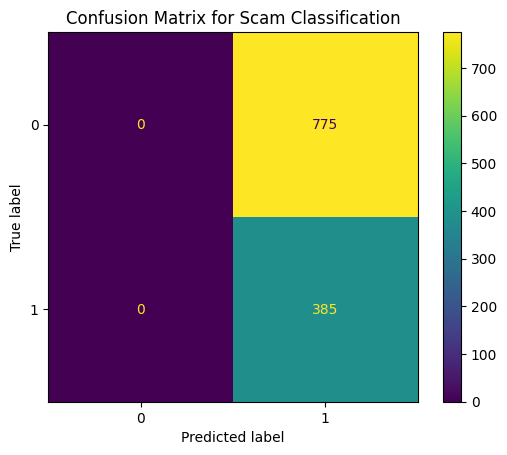

Test Loss: 0.1319, Test Accuracy: 0.3319, F1: 0.4984, ROC-AUC: 0.9977  (thresh 0)
Reasonable thresholds:
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Shiba Inu coin Whale Buys 131 Billion Coins: $SHIB Rally Incoming?   Don’t be fooled by manipulation!'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'as in memecoin taxes. Frogs still pay IRS taxes.'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'PEPE (Pepe), SWELL (Swell Network), SYRUP (Syrup fi), PUFFER (Puffer), and WIF (Dog Wif Hat) are now available for custody on Coinbase Prime!   Availability of these assets may be restricted based on custodian entity and customer jurisdiction.'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': "Ok lets get mathematical here.  Market capitalisation of the S&P500 is approximately $44 TRILLION.  Market capitalisation of SPX6900 is approximately $12.3 million.  6900 is 13.8x more S&P's than 500 (6900/500 = 13.8).  This means that the fair value of SPX6900 is $607.2 Trillio

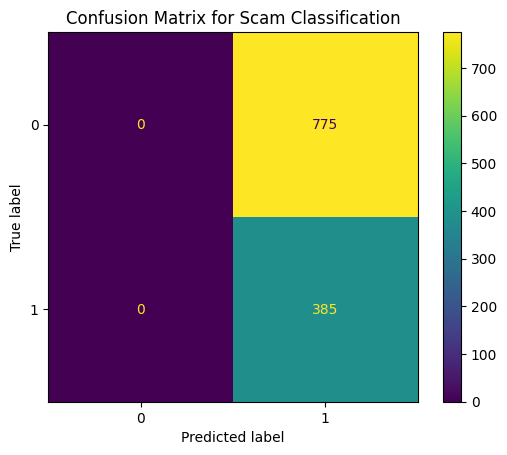

Test Loss: 0.1319, Test Accuracy: 0.3319, F1: 0.4984, ROC-AUC: 0.9977  (thresh 0.00)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Engagement in Crypto-Asset-Related Activities by Federal Reserve- Supervised Banking Organization <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'lmao'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': "Hop on, let's take a ride"}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'Rest in peace, dear Kabosu.   You will be sorely missed  But we find solace in knowing you will live on forever - not only in the blockchain that carries your legacy, but also in the hearts of countless people around the world that have been touched by your digital presence.'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Are we running out of time?'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': "Oh Lawd, He Comin'"}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': '#Bitcoin'}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'Let’

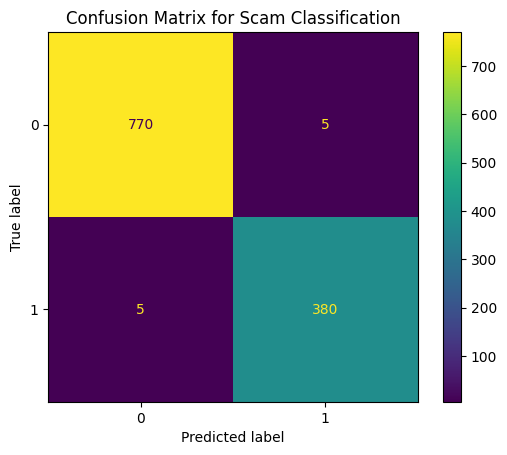

Test Loss: 0.1319, Test Accuracy: 0.9914, F1: 0.9870, ROC-AUC: 0.9977  (thresh 0.05)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Engagement in Crypto-Asset-Related Activities by Federal Reserve- Supervised Banking Organization <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'lmao'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': "Hop on, let's take a ride"}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'Rest in peace, dear Kabosu.   You will be sorely missed  But we find solace in knowing you will live on forever - not only in the blockchain that carries your legacy, but also in the hearts of countless people around the world that have been touched by your digital presence.'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': '<url>'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Are we running out of time?'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': "Oh Lawd, He Comin'"}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'Let’s t

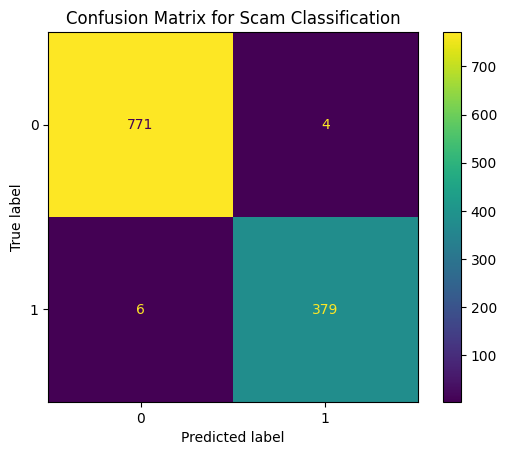

Test Loss: 0.1319, Test Accuracy: 0.9914, F1: 0.9870, ROC-AUC: 0.9977  (thresh 0.10)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Engagement in Crypto-Asset-Related Activities by Federal Reserve- Supervised Banking Organization <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'lmao'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': "Hop on, let's take a ride"}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'Rest in peace, dear Kabosu.   You will be sorely missed  But we find solace in knowing you will live on forever - not only in the blockchain that carries your legacy, but also in the hearts of countless people around the world that have been touched by your digital presence.'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': '<url>'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Are we running out of time?'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': "Oh Lawd, He Comin'"}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'What a 

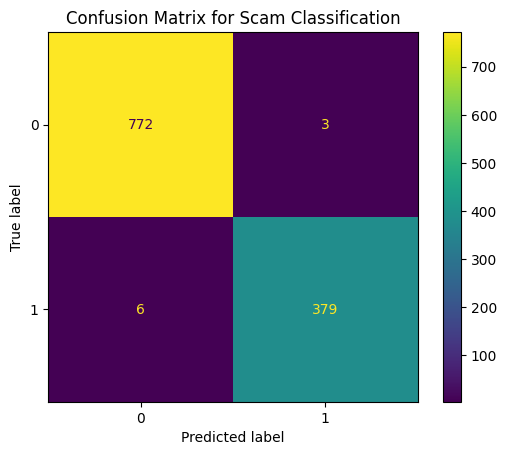

Test Loss: 0.1319, Test Accuracy: 0.9922, F1: 0.9883, ROC-AUC: 0.9977  (thresh 0.15)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Engagement in Crypto-Asset-Related Activities by Federal Reserve- Supervised Banking Organization <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'lmao'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': "Hop on, let's take a ride"}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'Rest in peace, dear Kabosu.   You will be sorely missed  But we find solace in knowing you will live on forever - not only in the blockchain that carries your legacy, but also in the hearts of countless people around the world that have been touched by your digital presence.'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': '<url>'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Are we running out of time?'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': "Oh Lawd, He Comin'"}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'What a 

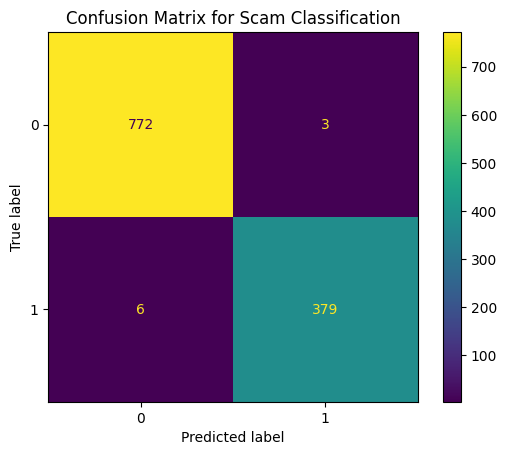

Test Loss: 0.1319, Test Accuracy: 0.9922, F1: 0.9883, ROC-AUC: 0.9977  (thresh 0.20)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Engagement in Crypto-Asset-Related Activities by Federal Reserve- Supervised Banking Organization <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'lmao'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': "Hop on, let's take a ride"}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'Rest in peace, dear Kabosu.   You will be sorely missed  But we find solace in knowing you will live on forever - not only in the blockchain that carries your legacy, but also in the hearts of countless people around the world that have been touched by your digital presence.'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': '<url>'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Are we running out of time?'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': "Oh Lawd, He Comin'"}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'What a 

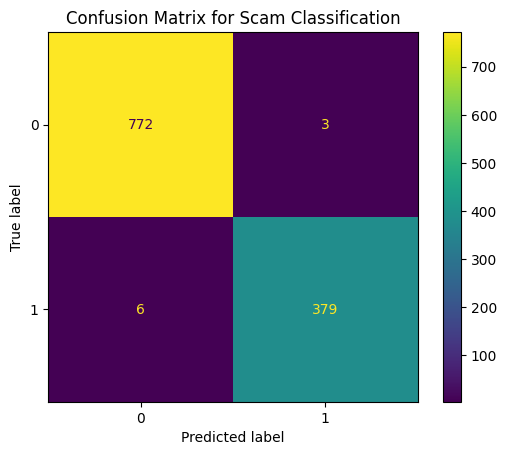

Test Loss: 0.1319, Test Accuracy: 0.9922, F1: 0.9883, ROC-AUC: 0.9977  (thresh 0.25)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Engagement in Crypto-Asset-Related Activities by Federal Reserve- Supervised Banking Organization <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'lmao'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': "Hop on, let's take a ride"}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'Rest in peace, dear Kabosu.   You will be sorely missed  But we find solace in knowing you will live on forever - not only in the blockchain that carries your legacy, but also in the hearts of countless people around the world that have been touched by your digital presence.'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': '<url>'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Are we running out of time?'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': "Oh Lawd, He Comin'"}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'What a 

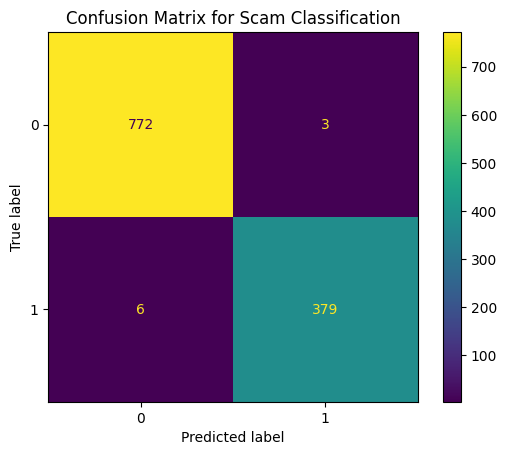

Test Loss: 0.1319, Test Accuracy: 0.9922, F1: 0.9883, ROC-AUC: 0.9977  (thresh 0.30)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Engagement in Crypto-Asset-Related Activities by Federal Reserve- Supervised Banking Organization <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'lmao'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': "Hop on, let's take a ride"}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'Rest in peace, dear Kabosu.   You will be sorely missed  But we find solace in knowing you will live on forever - not only in the blockchain that carries your legacy, but also in the hearts of countless people around the world that have been touched by your digital presence.'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': '<url>'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Are we running out of time?'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': "Oh Lawd, He Comin'"}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'What a 

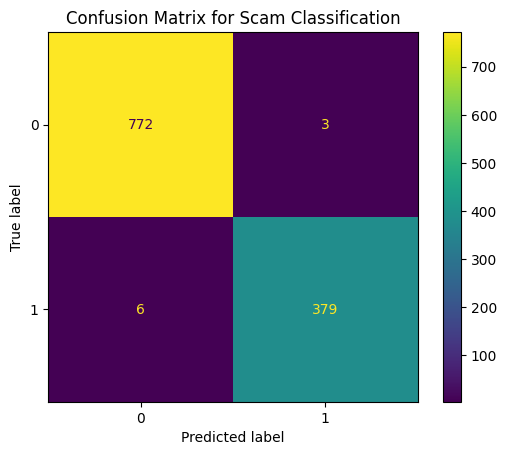

Test Loss: 0.1319, Test Accuracy: 0.9922, F1: 0.9883, ROC-AUC: 0.9977  (thresh 0.35)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Engagement in Crypto-Asset-Related Activities by Federal Reserve- Supervised Banking Organization <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'lmao'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': "Hop on, let's take a ride"}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'Rest in peace, dear Kabosu.   You will be sorely missed  But we find solace in knowing you will live on forever - not only in the blockchain that carries your legacy, but also in the hearts of countless people around the world that have been touched by your digital presence.'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': '<url>'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Are we running out of time?'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': "Oh Lawd, He Comin'"}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'What a 

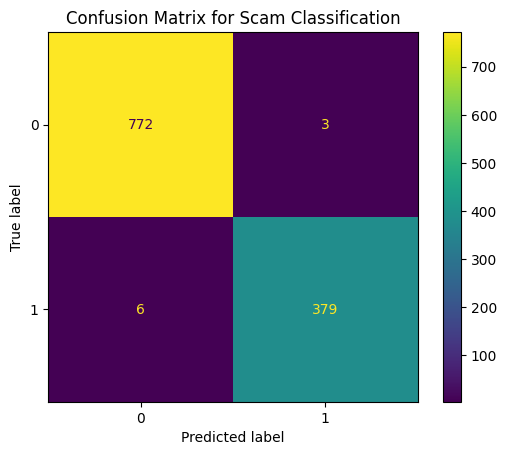

Test Loss: 0.1319, Test Accuracy: 0.9922, F1: 0.9883, ROC-AUC: 0.9977  (thresh 0.40)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Engagement in Crypto-Asset-Related Activities by Federal Reserve- Supervised Banking Organization <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'lmao'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': "Hop on, let's take a ride"}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'Rest in peace, dear Kabosu.   You will be sorely missed  But we find solace in knowing you will live on forever - not only in the blockchain that carries your legacy, but also in the hearts of countless people around the world that have been touched by your digital presence.'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': '<url>'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Are we running out of time?'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': "Oh Lawd, He Comin'"}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'What a 

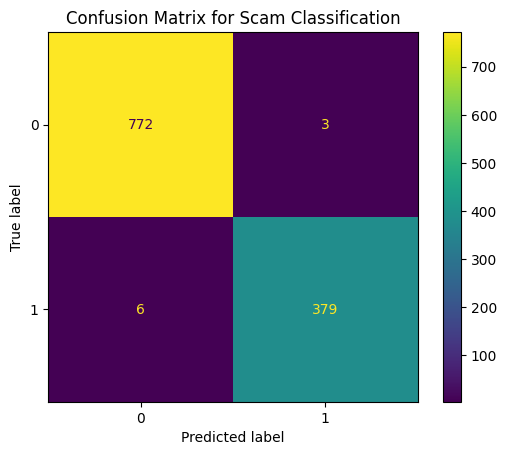

Test Loss: 0.1319, Test Accuracy: 0.9922, F1: 0.9883, ROC-AUC: 0.9977  (thresh 0.45)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Engagement in Crypto-Asset-Related Activities by Federal Reserve- Supervised Banking Organization <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'lmao'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': "Hop on, let's take a ride"}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'Rest in peace, dear Kabosu.   You will be sorely missed  But we find solace in knowing you will live on forever - not only in the blockchain that carries your legacy, but also in the hearts of countless people around the world that have been touched by your digital presence.'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': '<url>'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Are we running out of time?'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': "Oh Lawd, He Comin'"}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'What a 

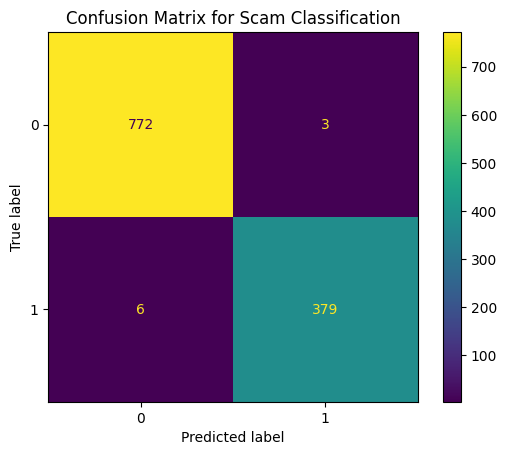

Test Loss: 0.1319, Test Accuracy: 0.9922, F1: 0.9883, ROC-AUC: 0.9977  (thresh 0.50)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Engagement in Crypto-Asset-Related Activities by Federal Reserve- Supervised Banking Organization <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'lmao'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': "Hop on, let's take a ride"}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'Rest in peace, dear Kabosu.   You will be sorely missed  But we find solace in knowing you will live on forever - not only in the blockchain that carries your legacy, but also in the hearts of countless people around the world that have been touched by your digital presence.'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': '<url>'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Are we running out of time?'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': "Oh Lawd, He Comin'"}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'What a 

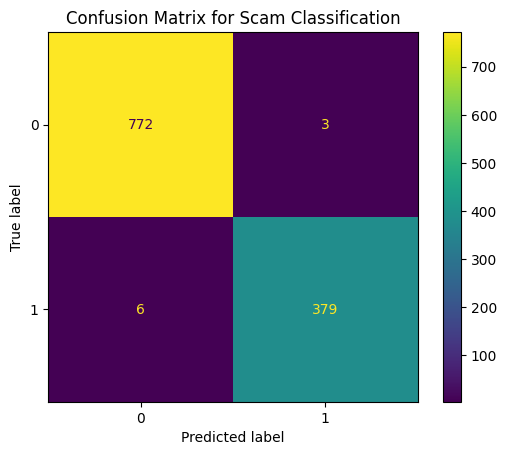

Test Loss: 0.1319, Test Accuracy: 0.9922, F1: 0.9883, ROC-AUC: 0.9977  (thresh 0.55)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Engagement in Crypto-Asset-Related Activities by Federal Reserve- Supervised Banking Organization <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'lmao'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': "Hop on, let's take a ride"}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'Rest in peace, dear Kabosu.   You will be sorely missed  But we find solace in knowing you will live on forever - not only in the blockchain that carries your legacy, but also in the hearts of countless people around the world that have been touched by your digital presence.'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': '<url>'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Are we running out of time?'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': "Oh Lawd, He Comin'"}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'What a 

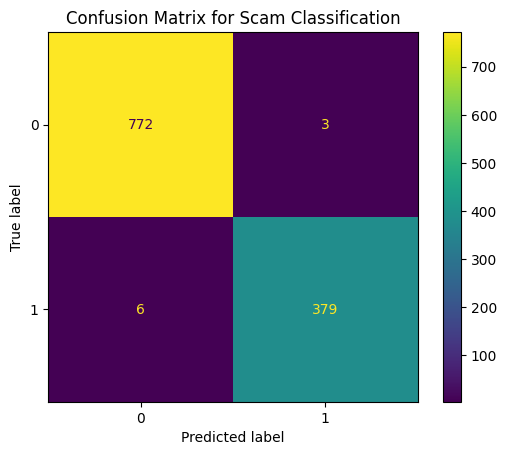

Test Loss: 0.1319, Test Accuracy: 0.9922, F1: 0.9883, ROC-AUC: 0.9977  (thresh 0.60)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Engagement in Crypto-Asset-Related Activities by Federal Reserve- Supervised Banking Organization <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'lmao'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': "Hop on, let's take a ride"}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'Rest in peace, dear Kabosu.   You will be sorely missed  But we find solace in knowing you will live on forever - not only in the blockchain that carries your legacy, but also in the hearts of countless people around the world that have been touched by your digital presence.'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': '<url>'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Are we running out of time?'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': "Oh Lawd, He Comin'"}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'What a 

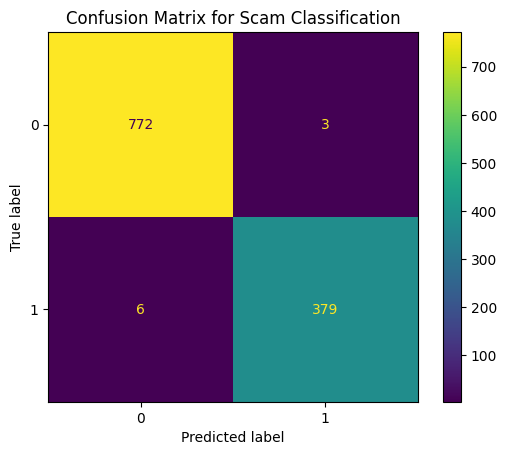

Test Loss: 0.1319, Test Accuracy: 0.9922, F1: 0.9883, ROC-AUC: 0.9977  (thresh 0.65)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Engagement in Crypto-Asset-Related Activities by Federal Reserve- Supervised Banking Organization <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'lmao'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': "Hop on, let's take a ride"}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'Rest in peace, dear Kabosu.   You will be sorely missed  But we find solace in knowing you will live on forever - not only in the blockchain that carries your legacy, but also in the hearts of countless people around the world that have been touched by your digital presence.'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': '<url>'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Are we running out of time?'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': "Oh Lawd, He Comin'"}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'What a 

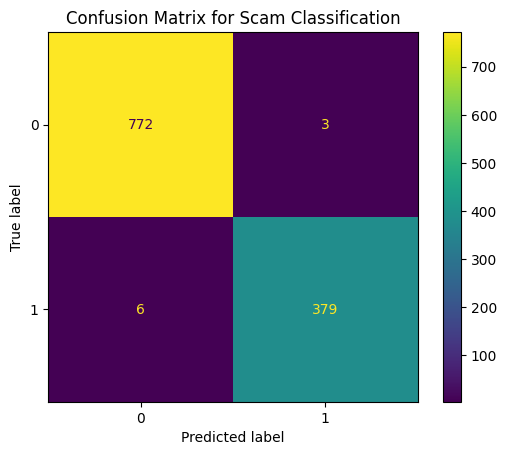

Test Loss: 0.1319, Test Accuracy: 0.9922, F1: 0.9883, ROC-AUC: 0.9977  (thresh 0.70)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Engagement in Crypto-Asset-Related Activities by Federal Reserve- Supervised Banking Organization <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'lmao'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': "Hop on, let's take a ride"}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'Rest in peace, dear Kabosu.   You will be sorely missed  But we find solace in knowing you will live on forever - not only in the blockchain that carries your legacy, but also in the hearts of countless people around the world that have been touched by your digital presence.'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': '<url>'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Are we running out of time?'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': "Oh Lawd, He Comin'"}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'What a 

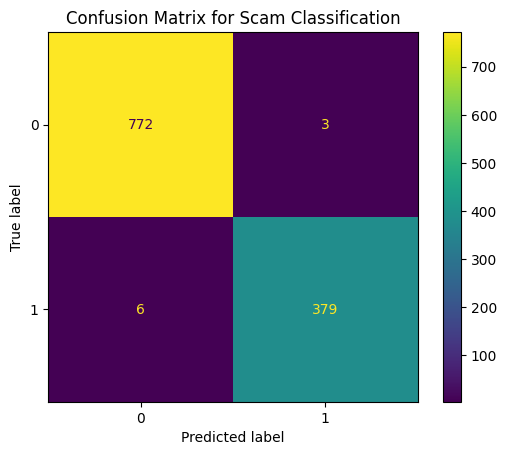

Test Loss: 0.1319, Test Accuracy: 0.9922, F1: 0.9883, ROC-AUC: 0.9977  (thresh 0.75)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Engagement in Crypto-Asset-Related Activities by Federal Reserve- Supervised Banking Organization <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'lmao'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': "Hop on, let's take a ride"}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'Rest in peace, dear Kabosu.   You will be sorely missed  But we find solace in knowing you will live on forever - not only in the blockchain that carries your legacy, but also in the hearts of countless people around the world that have been touched by your digital presence.'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': '<url>'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Are we running out of time?'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': "Oh Lawd, He Comin'"}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'What a 

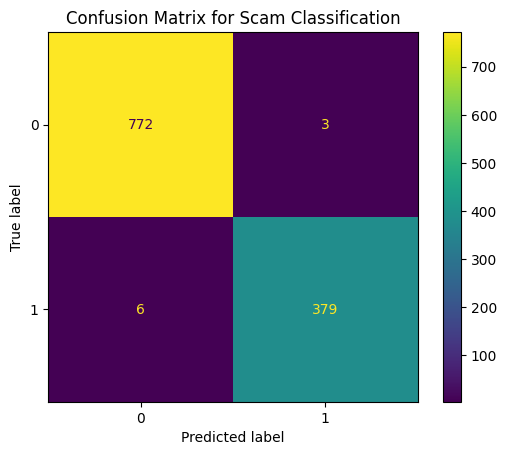

Test Loss: 0.1319, Test Accuracy: 0.9922, F1: 0.9883, ROC-AUC: 0.9977  (thresh 0.80)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Engagement in Crypto-Asset-Related Activities by Federal Reserve- Supervised Banking Organization <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'lmao'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': "Hop on, let's take a ride"}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'Rest in peace, dear Kabosu.   You will be sorely missed  But we find solace in knowing you will live on forever - not only in the blockchain that carries your legacy, but also in the hearts of countless people around the world that have been touched by your digital presence.'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': '<url>'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Are we running out of time?'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': "Oh Lawd, He Comin'"}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'What a 

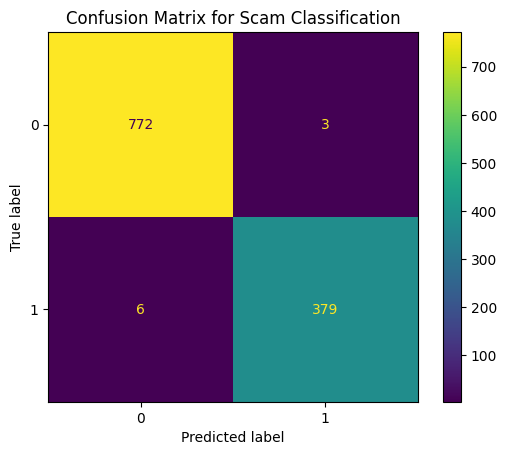

Test Loss: 0.1319, Test Accuracy: 0.9922, F1: 0.9883, ROC-AUC: 0.9977  (thresh 0.85)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Engagement in Crypto-Asset-Related Activities by Federal Reserve- Supervised Banking Organization <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'lmao'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': "Hop on, let's take a ride"}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'Rest in peace, dear Kabosu.   You will be sorely missed  But we find solace in knowing you will live on forever - not only in the blockchain that carries your legacy, but also in the hearts of countless people around the world that have been touched by your digital presence.'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': '<url>'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Are we running out of time?'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': "Oh Lawd, He Comin'"}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'What a 

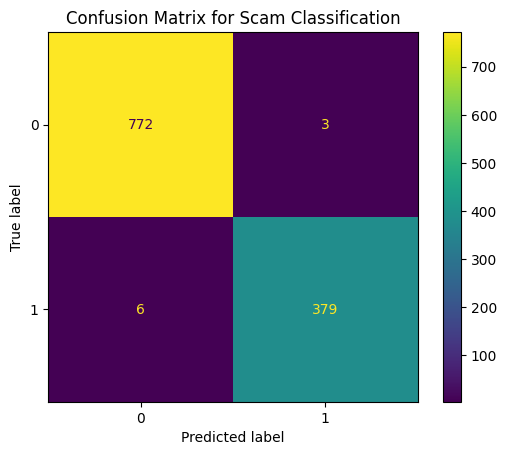

Test Loss: 0.1319, Test Accuracy: 0.9922, F1: 0.9883, ROC-AUC: 0.9977  (thresh 0.90)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Engagement in Crypto-Asset-Related Activities by Federal Reserve- Supervised Banking Organization <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'lmao'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': "Hop on, let's take a ride"}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'Rest in peace, dear Kabosu.   You will be sorely missed  But we find solace in knowing you will live on forever - not only in the blockchain that carries your legacy, but also in the hearts of countless people around the world that have been touched by your digital presence.'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': '<url>'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': 'Are we running out of time?'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': "Oh Lawd, He Comin'"}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'What a 

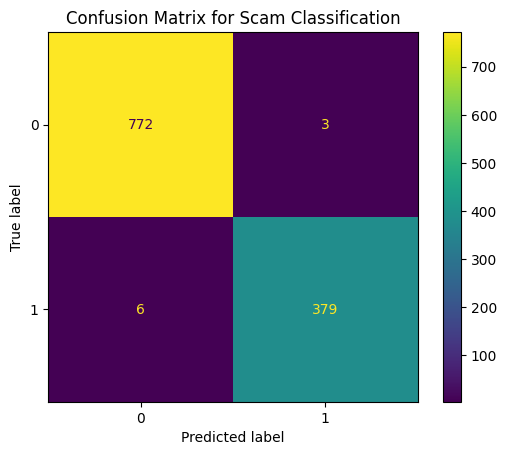

Test Loss: 0.1319, Test Accuracy: 0.9922, F1: 0.9883, ROC-AUC: 0.9977  (thresh 0.95)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'interesting stuff @foldfinance   src: <url>'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': '5/  @ParallelFi  launched its own non-custodial multichain wallet extension. The v.1 of the wallet focuses mainly on Parallel native use cases, with support for all core assets within the Polkadot &  @kusamanetwork  ecosystem coming later this year. Parallel Wallet v1 is officially here!  To read more: <url>'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Information is Beautiful  Thanks  @OlaStenberg__'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'USDT/PARA Pair is now sitting at 354k TVL, more than 4x’ed from the 78k TVL last Friday.  Parallel AMM now has the largest native USDT pool on Polkadot, by a lot.   We expect this number to grow exponentially as more parachains start to adopt USDT for their ecosystem.'}
False neg: {'coin_n

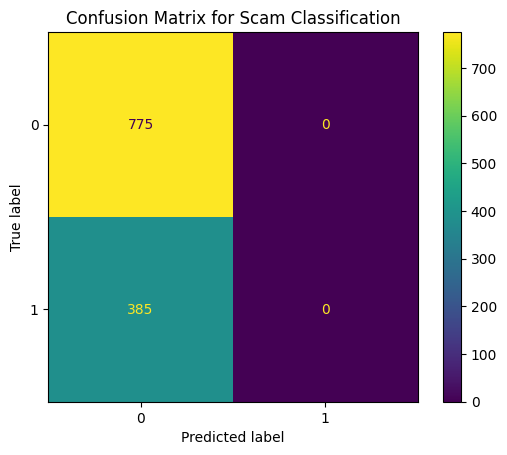

Test Loss: 0.1319, Test Accuracy: 0.6681, F1: 0.0000, ROC-AUC: 0.9977  (thresh 1.00)


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt


def evaluate_model(model, test_data, criterion, threshold):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    all_tweets = []

    with torch.no_grad():
        for batch in test_data:
            inputs, labels, attn_masks, tweets = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            attn_masks = attn_masks.to(device)
            all_tweets.extend(tweets)

            #roc-auc
            outputs = model(inputs, attn_masks)
            probs = torch.sigmoid(outputs.squeeze())
            all_probs.extend(probs.cpu().numpy())

            loss = criterion(outputs.squeeze(), labels.float())
            total_loss += loss.item()
            preds = torch.sigmoid(outputs.squeeze())
            preds = (preds > threshold).long()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_data)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    for i, pred in enumerate(all_preds):
      if pred != all_labels[i]:
        if all_labels[i] == 1:
          print(f"False neg: {all_tweets[i]}")
        if all_labels[i] == 0:
          print(f"False pos: {all_tweets[i]}")

    fscore = f1_score(np.array(all_labels), np.array(all_preds))
    roc_auc = roc_auc_score(np.array(all_labels), np.array(all_probs))
    cm = confusion_matrix(all_labels, all_preds)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
    cm_display.plot()
    plt.title("Confusion Matrix for Scam Classification")
    plt.show()

    return avg_loss, accuracy, fscore, roc_auc

print("Edge cases:")
test_loss, test_accuracy, test_fscore, roc_auc = evaluate_model(model, test_data, criterion, 1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1: {test_fscore:.4f}, ROC-AUC: {roc_auc:.4f} (thresh 1)")
test_loss, test_accuracy, test_fscore, roc_auc = evaluate_model(model, test_data, criterion, 0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1: {test_fscore:.4f}, ROC-AUC: {roc_auc:.4f}  (thresh 0)")

print("Reasonable thresholds:")
for threshold in np.linspace(0, 1, 21):
    test_loss, test_accuracy, test_fscore, roc_auc = evaluate_model(model, test_data, criterion, threshold)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1: {test_fscore:.4f}, ROC-AUC: {roc_auc:.4f}  (thresh {threshold:.2f})")

Relabeling for zero-shot on PARA

In [ ]:
import json
from typing import List
import random
import torch
import gc

def load_and_label(filenames: List[str], label: int) -> List[dict]:
    """Load tweets from a list of JSON filenames and assign the given label.

    Args:
        filenames: List of file paths.
        label: The label to assign (e.g., 1 for scam, 0 for legit).

    Returns:
        A list of tweet dictionaries with the added 'label' key.
    """
    all_tweets = []
    for filename in filenames:
        with open(filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
        for tweet in data:
            tweet['label'] = label
        all_tweets.extend(data)
    return all_tweets


scam_train_files = [
    "DEFI100_tweets.json",
    "BALD_tweets.json",
    "ANUBIS_tweets.json",
    "FOLD_tweets.json",
    "MAP_tweets.json",
    "OC_tweets.json",
    "PNUT_tweets.json",
    "THODEX_tweets.json"
]


scam_test_files = ["PARA_tweets.json"]


legit_files = [
    "DOGE_tweets.json",
    "FART_tweets.json",
    "GIGA_tweets.json",
    "PEPE_tweets.json",
    "SHIB_tweets.json",
    "SPX_tweets.json",
    "WIF_tweets.json"
]


torch.cuda.empty_cache()
gc.collect()


train_scam = load_and_label(scam_train_files, label=1)
train_legit = load_and_label(legit_files, label=0)
train_tweets = train_scam + train_legit

test_tweets = load_and_label(scam_test_files, label=1)


random.shuffle(train_tweets)

train_embeddings = InputFormatter(config, train_tweets)
test_embeddings = InputFormatter(config, test_tweets)

print("Train xdata shape:", train_embeddings.xdata.shape)
print("Test xdata shape:", test_embeddings.xdata.shape)


train_data = [(train_embeddings.xdata, train_embeddings.ydata, train_embeddings.attn_masks)]
test_data  = [(test_embeddings.xdata, test_embeddings.ydata, test_embeddings.attn_masks)]


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Train xdata shape: torch.Size([5227, 200])
Test xdata shape: torch.Size([570, 200])


In [ ]:

from torch.utils.data import TensorDataset, DataLoader


batch_size = 32

train_dataset = TensorDataset(train_embeddings.xdata, train_embeddings.ydata, train_embeddings.attn_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
config = SCConfig(block_size=200, drop_rate=0.3, nhid=768, nlayers=2, decoder_layers=1)
model = ScamClassifier(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
training_config = TrainingConfig(epochs=10, optimizer=optimizer, criterion=criterion)

def train_one_epoch(epoch: int, model, train_loader, training_config, clip: float) -> float:
    model.train()
    total_loss = 0.0
    for inputs, labels, attn_masks in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        attn_masks = attn_masks.to(device)

        training_config.optimizer.zero_grad()
        outputs = model(inputs, attn_masks)
        loss = training_config.criterion(outputs.squeeze(), labels.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        training_config.optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")
    return avg_loss

def train_model(model, train_loader, training_config, clip: float):
    for epoch in range(1, training_config.epochs + 1):
        train_one_epoch(epoch, model, train_loader, training_config, clip)


train_model(model, train_loader, training_config, clip=1.0)

Epoch 1: Loss = 0.1089
Epoch 2: Loss = 0.0411
Epoch 3: Loss = 0.0209
Epoch 4: Loss = 0.0200
Epoch 5: Loss = 0.0151
Epoch 6: Loss = 0.0118
Epoch 7: Loss = 0.0117
Epoch 8: Loss = 0.0107
Epoch 9: Loss = 0.0095
Epoch 10: Loss = 0.0058


In [ ]:
def evaluate_model(model, test_data, criterion, threshold):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_data:
            inputs, labels, attn_masks = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            attn_masks = attn_masks.to(device)

            outputs = model(inputs, attn_masks)
            loss = criterion(outputs.squeeze(), labels.float())
            total_loss += loss.item()
            preds = torch.sigmoid(outputs.squeeze())
            #decision threshold
            # print(f"preds: {preds}")
            preds = (preds > threshold).long()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_data)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    return avg_loss, accuracy
print("Edge cases:")
test_loss, test_accuracy = evaluate_model(model, test_data, criterion, 1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f} (thresh 1)")
test_loss, test_accuracy = evaluate_model(model, test_data, criterion, 0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f} (thresh 0)")
print("Reasonable thresholds:")
for threshold in range(0, 20):
  threshold /= 20.0
  test_loss, test_accuracy = evaluate_model(model, test_data, criterion, threshold)
  print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f} (thresh {threshold})")

Edge cases:
Test Loss: 0.3474, Test Accuracy: 0.0000 (thresh 1)
Test Loss: 0.3474, Test Accuracy: 1.0000 (thresh 0)
Reasonable thresholds:
Test Loss: 0.3474, Test Accuracy: 1.0000 (thresh 0.0)
Test Loss: 0.3474, Test Accuracy: 0.9561 (thresh 0.05)
Test Loss: 0.3474, Test Accuracy: 0.9544 (thresh 0.1)
Test Loss: 0.3474, Test Accuracy: 0.9544 (thresh 0.15)
Test Loss: 0.3474, Test Accuracy: 0.9544 (thresh 0.2)
Test Loss: 0.3474, Test Accuracy: 0.9544 (thresh 0.25)
Test Loss: 0.3474, Test Accuracy: 0.9544 (thresh 0.3)
Test Loss: 0.3474, Test Accuracy: 0.9544 (thresh 0.35)
Test Loss: 0.3474, Test Accuracy: 0.9544 (thresh 0.4)
Test Loss: 0.3474, Test Accuracy: 0.9544 (thresh 0.45)
Test Loss: 0.3474, Test Accuracy: 0.9544 (thresh 0.5)
Test Loss: 0.3474, Test Accuracy: 0.9526 (thresh 0.55)
Test Loss: 0.3474, Test Accuracy: 0.9509 (thresh 0.6)
Test Loss: 0.3474, Test Accuracy: 0.9509 (thresh 0.65)
Test Loss: 0.3474, Test Accuracy: 0.9509 (thresh 0.7)
Test Loss: 0.3474, Test Accuracy: 0.9491 (th

Relabeling for Zero Shot on DOGE

In [ ]:
import json
from typing import List
import random
import torch
import gc

def load_and_label(filenames: List[str], label: int) -> List[dict]:
    """Load tweets from a list of JSON filenames and assign the given label.

    Args:
        filenames: List of file paths.
        label: The label to assign (e.g., 1 for scam, 0 for legit).

    Returns:
        A list of tweet dictionaries with the added 'label' key.
    """
    all_tweets = []
    for filename in filenames:
        with open(filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
        for tweet in data:
            tweet['label'] = label
        all_tweets.extend(data)
    return all_tweets


scam_train_files = [
    "DEFI100_tweets.json",
    "BALD_tweets.json",
    "ANUBIS_tweets.json",
    "FOLD_tweets.json",
    "PARA_tweets.json",
    "MAP_tweets.json",
    "OC_tweets.json",
    "PNUT_tweets.json",
    "THODEX_tweets.json"
]


legit_test_files = ["DOGE_tweets.json"]


legit_files = [
    "FART_tweets.json",
    "GIGA_tweets.json",
    "PEPE_tweets.json",
    "SHIB_tweets.json",
    "SPX_tweets.json",
    "WIF_tweets.json"
]


torch.cuda.empty_cache()
gc.collect()


train_scam = load_and_label(scam_train_files, label=1)
train_legit = load_and_label(legit_files, label=0)
train_tweets = train_scam + train_legit

test_tweets = load_and_label(legit_test_files, label=0)

random.shuffle(train_tweets)

train_embeddings = InputFormatter(config, train_tweets)
test_embeddings = InputFormatter(config, test_tweets)

print("Train xdata shape:", train_embeddings.xdata.shape)
print("Test xdata shape:", test_embeddings.xdata.shape)

train_data = [(train_embeddings.xdata, train_embeddings.ydata, train_embeddings.attn_masks)]
test_data  = [(test_embeddings.xdata, test_embeddings.ydata, test_embeddings.attn_masks)]


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Train xdata shape: torch.Size([5027, 200])
Test xdata shape: torch.Size([770, 200])


In [ ]:

from torch.utils.data import TensorDataset, DataLoader


batch_size = 32

train_dataset = TensorDataset(train_embeddings.xdata, train_embeddings.ydata, train_embeddings.attn_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
config = SCConfig(block_size=200, drop_rate=0.3, nhid=768, nlayers=2, decoder_layers=1)
model = ScamClassifier(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
training_config = TrainingConfig(epochs=10, optimizer=optimizer, criterion=criterion)

def train_one_epoch(epoch: int, model, train_loader, training_config, clip: float) -> float:
    model.train()
    total_loss = 0.0
    for inputs, labels, attn_masks in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        attn_masks = attn_masks.to(device)

        training_config.optimizer.zero_grad()
        outputs = model(inputs, attn_masks)
        loss = training_config.criterion(outputs.squeeze(), labels.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        training_config.optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")
    return avg_loss

def train_model(model, train_loader, training_config, clip: float):
    for epoch in range(1, training_config.epochs + 1):
        train_one_epoch(epoch, model, train_loader, training_config, clip)

train_model(model, train_loader, training_config, clip=1.0)

Epoch 1: Loss = 0.0294
Epoch 2: Loss = 0.0196
Epoch 3: Loss = 0.0172
Epoch 4: Loss = 0.0085
Epoch 5: Loss = 0.0052
Epoch 6: Loss = 0.0082
Epoch 7: Loss = 0.0057
Epoch 8: Loss = 0.0122
Epoch 9: Loss = 0.0070
Epoch 10: Loss = 0.0039


In [ ]:
def evaluate_model(model, test_data, criterion, threshold):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_data:
            inputs, labels, attn_masks = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            attn_masks = attn_masks.to(device)

            outputs = model(inputs, attn_masks)
            loss = criterion(outputs.squeeze(), labels.float())
            total_loss += loss.item()
            preds = torch.sigmoid(outputs.squeeze())
            #decision threshold
            # print(f"preds: {preds}")
            preds = (preds > threshold).long()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_data)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    return avg_loss, accuracy
print("Edge cases:")
test_loss, test_accuracy = evaluate_model(model, test_data, criterion, 1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f} (thresh 1)")
test_loss, test_accuracy = evaluate_model(model, test_data, criterion, 0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f} (thresh 0)")
print("Reasonable thresholds:")
for threshold in range(0, 20):
  threshold /= 20.0
  test_loss, test_accuracy = evaluate_model(model, test_data, criterion, threshold)
  print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f} (thresh {threshold})")

Edge cases:
Test Loss: 0.3936, Test Accuracy: 1.0000 (thresh 1)
Test Loss: 0.3936, Test Accuracy: 0.0000 (thresh 0)
Reasonable thresholds:
Test Loss: 0.3936, Test Accuracy: 0.0000 (thresh 0.0)
Test Loss: 0.3936, Test Accuracy: 0.9636 (thresh 0.05)
Test Loss: 0.3936, Test Accuracy: 0.9636 (thresh 0.1)
Test Loss: 0.3936, Test Accuracy: 0.9636 (thresh 0.15)
Test Loss: 0.3936, Test Accuracy: 0.9636 (thresh 0.2)
Test Loss: 0.3936, Test Accuracy: 0.9636 (thresh 0.25)
Test Loss: 0.3936, Test Accuracy: 0.9636 (thresh 0.3)
Test Loss: 0.3936, Test Accuracy: 0.9636 (thresh 0.35)
Test Loss: 0.3936, Test Accuracy: 0.9649 (thresh 0.4)
Test Loss: 0.3936, Test Accuracy: 0.9662 (thresh 0.45)
Test Loss: 0.3936, Test Accuracy: 0.9662 (thresh 0.5)
Test Loss: 0.3936, Test Accuracy: 0.9688 (thresh 0.55)
Test Loss: 0.3936, Test Accuracy: 0.9688 (thresh 0.6)
Test Loss: 0.3936, Test Accuracy: 0.9688 (thresh 0.65)
Test Loss: 0.3936, Test Accuracy: 0.9688 (thresh 0.7)
Test Loss: 0.3936, Test Accuracy: 0.9688 (th

Zero Shot on Both Classes

In [ ]:
import json
from typing import List
import random
import torch
import gc

def load_and_label(filenames: List[str], label: int) -> List[dict]:
    """Load tweets from a list of JSON filenames and assign the given label.

    Args:
        filenames: List of file paths.
        label: The label to assign (e.g., 1 for scam, 0 for legit).

    Returns:
        A list of tweet dictionaries with the added 'label' key.
    """
    all_tweets = []
    for filename in filenames:
        with open(filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
        for tweet in data:
            tweet['label'] = label
        all_tweets.extend(data)
    return all_tweets


scam_train_files = [
    "DEFI100_tweets.json",
    "BALD_tweets.json",
    "ANUBIS_tweets.json",
    "FOLD_tweets.json",
    "MAP_tweets.json",
    "OC_tweets.json",
    "PNUT_tweets.json",
    "THODEX_tweets.json"
]


legit_test_files = ["DOGE_tweets.json"]
scam_test_files = ["PARA_tweets.json"]

legit_files = [
    "FART_tweets.json",
    "GIGA_tweets.json",
    "PEPE_tweets.json",
    "SHIB_tweets.json",
    "SPX_tweets.json",
    "WIF_tweets.json"
]


torch.cuda.empty_cache()
gc.collect()

train_scam = load_and_label(scam_train_files, label=1)
train_legit = load_and_label(legit_files, label=0)
train_tweets = train_scam + train_legit

test_legit_tweets = load_and_label(legit_test_files, label=0)
test_scam_tweets = load_and_label(scam_test_files, label=1)
test_tweets = test_legit_tweets + test_scam_tweets

random.shuffle(train_tweets)

train_embeddings = InputFormatter(config, train_tweets)
test_embeddings = InputFormatter(config, test_tweets)

print("Train xdata shape:", train_embeddings.xdata.shape)
print("Test xdata shape:", test_embeddings.xdata.shape)

train_data = [(train_embeddings.xdata, train_embeddings.ydata, train_embeddings.attn_masks)]
test_data  = [(test_embeddings.xdata, test_embeddings.ydata, test_embeddings.attn_masks)]


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Train xdata shape: torch.Size([4457, 200])
Test xdata shape: torch.Size([1340, 200])


In [ ]:

from torch.utils.data import TensorDataset, DataLoader


batch_size = 32

train_dataset = TensorDataset(train_embeddings.xdata, train_embeddings.ydata, train_embeddings.attn_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
config = SCConfig(block_size=200, drop_rate=0.3, nhid=768, nlayers=2, decoder_layers=1)
model = ScamClassifier(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
training_config = TrainingConfig(epochs=10, optimizer=optimizer, criterion=criterion)

def train_one_epoch(epoch: int, model, train_loader, training_config, clip: float) -> float:
    model.train()
    total_loss = 0.0
    for inputs, labels, attn_masks in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        attn_masks = attn_masks.to(device)

        training_config.optimizer.zero_grad()
        outputs = model(inputs, attn_masks)
        loss = training_config.criterion(outputs.squeeze(), labels.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        training_config.optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")
    return avg_loss

def train_model(model, train_loader, training_config, clip: float):
    for epoch in range(1, training_config.epochs + 1):
        train_one_epoch(epoch, model, train_loader, training_config, clip)

train_model(model, train_loader, training_config, clip=1.0)

Epoch 1: Loss = 0.0862
Epoch 2: Loss = 0.0328
Epoch 3: Loss = 0.0165
Epoch 4: Loss = 0.0161
Epoch 5: Loss = 0.0108
Epoch 6: Loss = 0.0125
Epoch 7: Loss = 0.0091
Epoch 8: Loss = 0.0083
Epoch 9: Loss = 0.0082
Epoch 10: Loss = 0.0100


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

def evaluate_model(model, test_data, criterion, threshold):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_data:
            inputs, labels, attn_masks = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            attn_masks = attn_masks.to(device)

            outputs = model(inputs, attn_masks)
            loss = criterion(outputs.squeeze(), labels.float())
            total_loss += loss.item()
            preds = torch.sigmoid(outputs.squeeze())
            preds = (preds > threshold).long()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_data)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    fscore = f1_score(np.array(all_labels), np.array(all_preds))

    return avg_loss, accuracy, fscore

print("Edge cases:")
test_loss, test_accuracy, test_fscore = evaluate_model(model, test_data, criterion, 1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1: {test_fscore:.4f} (thresh 1)")
test_loss, test_accuracy, test_fscore = evaluate_model(model, test_data, criterion, 0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1: {test_fscore:.4f} (thresh 0)")

print("Reasonable thresholds:")
for threshold in np.linspace(0, 1, 21):
    test_loss, test_accuracy, test_fscore = evaluate_model(model, test_data, criterion, threshold)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1: {test_fscore:.4f} (thresh {threshold:.2f})")

Edge cases:
Test Loss: 0.4475, Test Accuracy: 0.5746, F1: 0.0000 (thresh 1)
Test Loss: 0.4475, Test Accuracy: 0.4254, F1: 0.5969 (thresh 0)
Reasonable thresholds:
Test Loss: 0.4475, Test Accuracy: 0.4254, F1: 0.5969 (thresh 0.00)
Test Loss: 0.4475, Test Accuracy: 0.9649, F1: 0.9575 (thresh 0.05)
Test Loss: 0.4475, Test Accuracy: 0.9649, F1: 0.9575 (thresh 0.10)
Test Loss: 0.4475, Test Accuracy: 0.9649, F1: 0.9575 (thresh 0.15)
Test Loss: 0.4475, Test Accuracy: 0.9649, F1: 0.9575 (thresh 0.20)
Test Loss: 0.4475, Test Accuracy: 0.9649, F1: 0.9575 (thresh 0.25)
Test Loss: 0.4475, Test Accuracy: 0.9649, F1: 0.9575 (thresh 0.30)
Test Loss: 0.4475, Test Accuracy: 0.9649, F1: 0.9575 (thresh 0.35)
Test Loss: 0.4475, Test Accuracy: 0.9649, F1: 0.9575 (thresh 0.40)
Test Loss: 0.4475, Test Accuracy: 0.9649, F1: 0.9575 (thresh 0.45)
Test Loss: 0.4475, Test Accuracy: 0.9649, F1: 0.9575 (thresh 0.50)
Test Loss: 0.4475, Test Accuracy: 0.9649, F1: 0.9575 (thresh 0.55)
Test Loss: 0.4475, Test Accuracy:

Name Masking

In [ ]:
from google.colab import drive


drive.mount('/content/drive')


%cd /content/drive/MyDrive/CS257/masked_coins


!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CS257/masked_coins
ANUBIS_masked_tweets.json   FOLD_masked_tweets.json  PNUT_masked_tweets.json
BALD_masked_tweets.json     GIGA_masked_tweets.json  SHIB_masked_tweets.json
DEFI100_masked_tweets.json  MAP_masked_tweets.json   SPX_masked_tweets.json
DOGE_masked_tweets.json     OC_masked_tweets.json    THODEX_masked_tweets.json
ETH_masked_tweets.json	    PARA_masked_tweets.json  WIF_masked_tweets.json
FART_masked_tweets.json     PEPE_masked_tweets.json


In [ ]:
import json

def load_and_label(filenames: List[str], label: int) -> List[dict]:
    """Load tweets from a list of JSON filenames and assign the given label to each tweet.

    Args:
        filenames: List of file paths.
        label: The label to assign (e.g., 1 for scam, 0 for legit).

    Returns:
        A list of tweet dictionaries with the added 'label' key.
    """
    all_tweets = []
    for filename in filenames:
        with open(filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
        for tweet in data:
            tweet['label'] = label
        all_tweets.extend(data)
    return all_tweets

scam_files = ["DEFI100_masked_tweets.json",
              "BALD_masked_tweets.json",
              "ANUBIS_masked_tweets.json",
              "FOLD_masked_tweets.json",
              "MAP_masked_tweets.json",
              "OC_masked_tweets.json",
              "PARA_masked_tweets.json",
              "PNUT_masked_tweets.json",
              "THODEX_masked_tweets.json"]

legit_files = ["DOGE_masked_tweets.json",
               "FART_masked_tweets.json",
              #  "ETH_masked_tweets.json",
               "GIGA_masked_tweets.json",
               "PEPE_masked_tweets.json",
               "SHIB_masked_tweets.json",
               "SPX_masked_tweets.json",
               "WIF_masked_tweets.json"]
torch.cuda.empty_cache()
import gc
gc.collect()
scam_tweets = load_and_label(scam_files, label=1)
legit_tweets = load_and_label(legit_files, label=0)
all_tweets = scam_tweets + legit_tweets
import random
random.shuffle(all_tweets)
split_idx = int(0.8 * len(all_tweets))
train_tweets = all_tweets[:split_idx]
test_tweets = all_tweets[split_idx:]
train_embeddings = InputFormatter(config, train_tweets)
test_embeddings = InputFormatter(config, test_tweets)
print("Train xdata shape:", train_embeddings.xdata.shape)
print("Test xdata shape:", test_embeddings.xdata.shape)
train_data = [(train_embeddings.xdata, train_embeddings.ydata, train_embeddings.attn_masks)]
test_data = [(test_embeddings.xdata, test_embeddings.ydata, test_embeddings.attn_masks, test_tweets)]


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Train xdata shape: torch.Size([4637, 200])
Test xdata shape: torch.Size([1160, 200])


In [ ]:

from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

train_dataset = TensorDataset(train_embeddings.xdata, train_embeddings.ydata, train_embeddings.attn_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
config = SCConfig(block_size=200, drop_rate=0.3, nhid=768, nlayers=2, decoder_layers=1)
model = ScamClassifier(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
training_config = TrainingConfig(epochs=10, optimizer=optimizer, criterion=criterion)

def train_one_epoch(epoch: int, model, train_loader, training_config, clip: float) -> float:
    model.train()
    total_loss = 0.0
    for inputs, labels, attn_masks in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        attn_masks = attn_masks.to(device)

        training_config.optimizer.zero_grad()
        outputs = model(inputs, attn_masks)
        loss = training_config.criterion(outputs.squeeze(), labels.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        training_config.optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")
    return avg_loss

def train_model(model, train_loader, training_config, clip: float):
    for epoch in range(1, training_config.epochs + 1):
        train_one_epoch(epoch, model, train_loader, training_config, clip)

train_model(model, train_loader, training_config, clip=1.0)

Epoch 1: Loss = 0.0494
Epoch 2: Loss = 0.0268
Epoch 3: Loss = 0.0187
Epoch 4: Loss = 0.0294
Epoch 5: Loss = 0.0158
Epoch 6: Loss = 0.0132
Epoch 7: Loss = 0.0054
Epoch 8: Loss = 0.0094
Epoch 9: Loss = 0.0063
Epoch 10: Loss = 0.0073


Edge cases:
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Enjoy the weekend'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Congratulations to the  @OlympusDAO  team and  @ohmzeus  - excited to see this new architecture in action  There are a few major pieces to this release: the core registry (Kernel), treasury, minter, governor, and finally, the range-bound stability (RBS) system, which was written about by @ohmzeus early this year (<url> and developed by the stallion @oightytag.'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Introducing AVS Compression: The future of restaking efficiency! ReStake once, earn multiple yields while reducing operational complexity and elimina

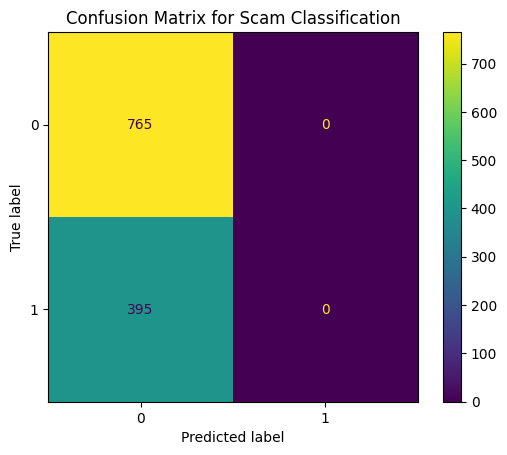

Test Loss: 0.2961, Test Accuracy: 0.6595, F1: 0.0000, ROC-AUC: 0.9931 (thresh 1)
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'I’m assembling a team  $[NAME]'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'The news everyone is talking about:  $[NAME] is now available for trading to US clients!  Trade here  <url>'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': '$[NAME] 10X+ more and $TREES 100X potential  <url>'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'Twas the night before Christmas, when all through the house, Not a creature was stirring, not even a mouse.  a good night to all $[NAME]'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': 'Aaaand another $1bn in $[NAME] perp volumes in last 24H Aaaand another $1bn in $[NAME] perp volumes in last 24H  x.com/osf_rekt/statu…'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'That’s literally all you have to do. $[NAME]'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'Update:   [NAME] is now a

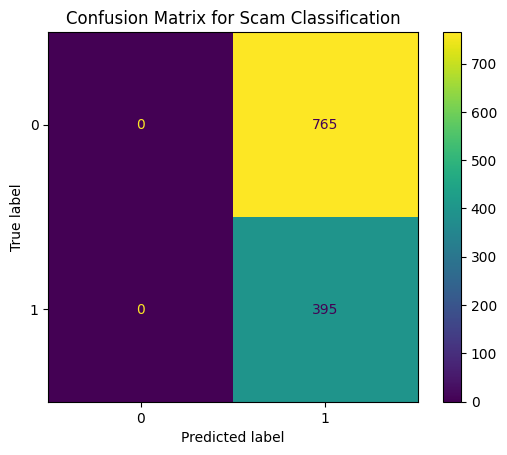

Test Loss: 0.2961, Test Accuracy: 0.3405, F1: 0.5080, ROC-AUC: 0.9931  (thresh 0)
Reasonable thresholds:
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'I’m assembling a team  $[NAME]'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'The news everyone is talking about:  $[NAME] is now available for trading to US clients!  Trade here  <url>'}
False pos: {'coin_name': 'SHIB', 'label': 0, 'text': '$[NAME] 10X+ more and $TREES 100X potential  <url>'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'Twas the night before Christmas, when all through the house, Not a creature was stirring, not even a mouse.  a good night to all $[NAME]'}
False pos: {'coin_name': 'WIF', 'label': 0, 'text': 'Aaaand another $1bn in $[NAME] perp volumes in last 24H Aaaand another $1bn in $[NAME] perp volumes in last 24H  x.com/osf_rekt/statu…'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'That’s literally all you have to do. $[NAME]'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': 'U

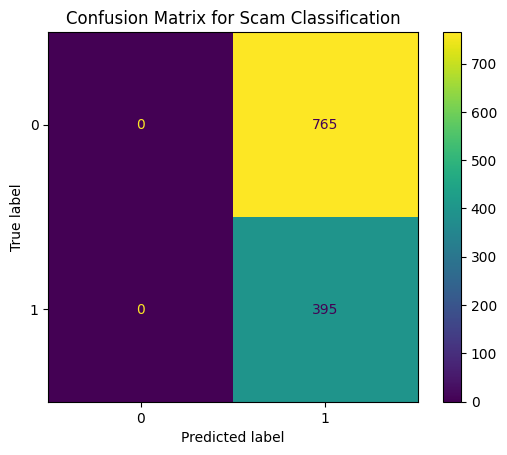

Test Loss: 0.2961, Test Accuracy: 0.3405, F1: 0.5080, ROC-AUC: 0.9931  (thresh 0.00)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'NYC done Peanut the Squirrel the same as Harambe #DoOnlyGoodEveryday to all creatures, great and small'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'Decentralized, as always.  Although the simple one-click yield might remind you of the old CEX days, this new feature is just as decentralized as any on-chain transactions.'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'We are the media now'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'You got a friend in me'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': '<url>'}
False neg: {'coin_

Test Loss: 0.2961, Test Accuracy: 0.9776, F1: 0.9666, ROC-AUC: 0.9931  (thresh 0.05)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'NYC done Peanut the Squirrel the same as Harambe #DoOnlyGoodEveryday to all creatures, great and small'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'Decentralized, as always.  Although the simple one-click yield might remind you of the old CEX days, this new feature is just as decentralized as any on-chain transactions.'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'We are the media now'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'You got a friend in me'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': '<url>'}
False neg: {'coin_

Test Loss: 0.2961, Test Accuracy: 0.9767, F1: 0.9653, ROC-AUC: 0.9931  (thresh 0.10)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'NYC done Peanut the Squirrel the same as Harambe #DoOnlyGoodEveryday to all creatures, great and small'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'Decentralized, as always.  Although the simple one-click yield might remind you of the old CEX days, this new feature is just as decentralized as any on-chain transactions.'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'We are the media now'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'You got a friend in me'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': '<url>'}
False neg: {'coin_

Test Loss: 0.2961, Test Accuracy: 0.9767, F1: 0.9653, ROC-AUC: 0.9931  (thresh 0.15)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'NYC done Peanut the Squirrel the same as Harambe #DoOnlyGoodEveryday to all creatures, great and small'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'Decentralized, as always.  Although the simple one-click yield might remind you of the old CEX days, this new feature is just as decentralized as any on-chain transactions.'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'We are the media now'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'You got a friend in me'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': '<url>'}
False neg: {'coin_

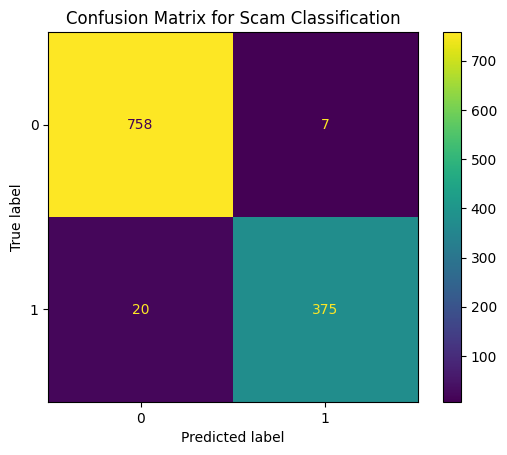

Test Loss: 0.2961, Test Accuracy: 0.9767, F1: 0.9653, ROC-AUC: 0.9931  (thresh 0.20)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'NYC done Peanut the Squirrel the same as Harambe #DoOnlyGoodEveryday to all creatures, great and small'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'Decentralized, as always.  Although the simple one-click yield might remind you of the old CEX days, this new feature is just as decentralized as any on-chain transactions.'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'We are the media now'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'You got a friend in me'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': '<url>'}
False neg: {'coin_

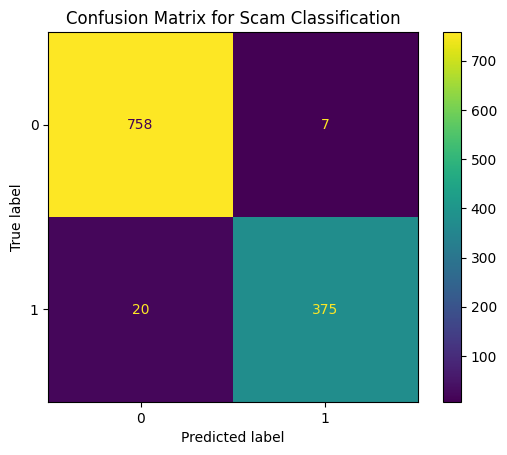

Test Loss: 0.2961, Test Accuracy: 0.9767, F1: 0.9653, ROC-AUC: 0.9931  (thresh 0.25)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'NYC done Peanut the Squirrel the same as Harambe #DoOnlyGoodEveryday to all creatures, great and small'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'Decentralized, as always.  Although the simple one-click yield might remind you of the old CEX days, this new feature is just as decentralized as any on-chain transactions.'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'We are the media now'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'You got a friend in me'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': '<url>'}
False neg: {'coin_

Test Loss: 0.2961, Test Accuracy: 0.9759, F1: 0.9639, ROC-AUC: 0.9931  (thresh 0.30)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'NYC done Peanut the Squirrel the same as Harambe #DoOnlyGoodEveryday to all creatures, great and small'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'Decentralized, as always.  Although the simple one-click yield might remind you of the old CEX days, this new feature is just as decentralized as any on-chain transactions.'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'We are the media now'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'You got a friend in me'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': '<url>'}
False neg: {'coin_

Test Loss: 0.2961, Test Accuracy: 0.9759, F1: 0.9639, ROC-AUC: 0.9931  (thresh 0.35)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'NYC done Peanut the Squirrel the same as Harambe #DoOnlyGoodEveryday to all creatures, great and small'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'Decentralized, as always.  Although the simple one-click yield might remind you of the old CEX days, this new feature is just as decentralized as any on-chain transactions.'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'We are the media now'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'You got a friend in me'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': '<url>'}
False neg: {'coin_

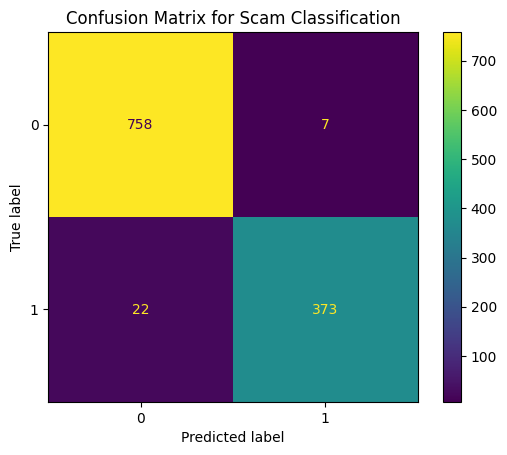

Test Loss: 0.2961, Test Accuracy: 0.9750, F1: 0.9626, ROC-AUC: 0.9931  (thresh 0.40)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'NYC done Peanut the Squirrel the same as Harambe #DoOnlyGoodEveryday to all creatures, great and small'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'Decentralized, as always.  Although the simple one-click yield might remind you of the old CEX days, this new feature is just as decentralized as any on-chain transactions.'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'We are the media now'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'You got a friend in me'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': '<url>'}
False neg: {'coin_

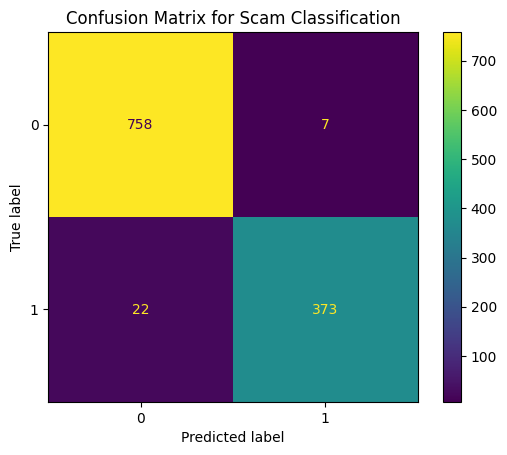

Test Loss: 0.2961, Test Accuracy: 0.9750, F1: 0.9626, ROC-AUC: 0.9931  (thresh 0.45)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'NYC done Peanut the Squirrel the same as Harambe #DoOnlyGoodEveryday to all creatures, great and small'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'Decentralized, as always.  Although the simple one-click yield might remind you of the old CEX days, this new feature is just as decentralized as any on-chain transactions.'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'We are the media now'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'You got a friend in me'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': '<url>'}
False neg: {'coin_

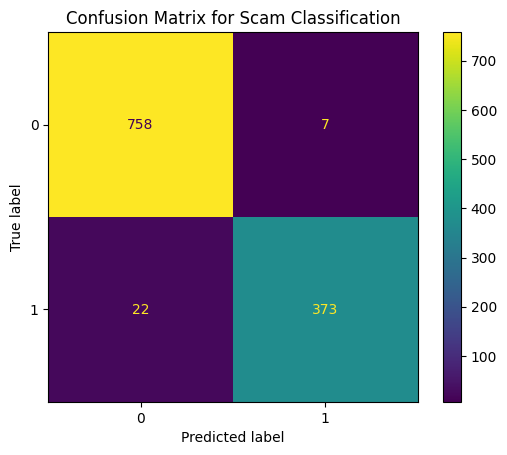

Test Loss: 0.2961, Test Accuracy: 0.9750, F1: 0.9626, ROC-AUC: 0.9931  (thresh 0.50)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'NYC done Peanut the Squirrel the same as Harambe #DoOnlyGoodEveryday to all creatures, great and small'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'Decentralized, as always.  Although the simple one-click yield might remind you of the old CEX days, this new feature is just as decentralized as any on-chain transactions.'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'We are the media now'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'You got a friend in me'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': '<url>'}
False neg: {'coin_

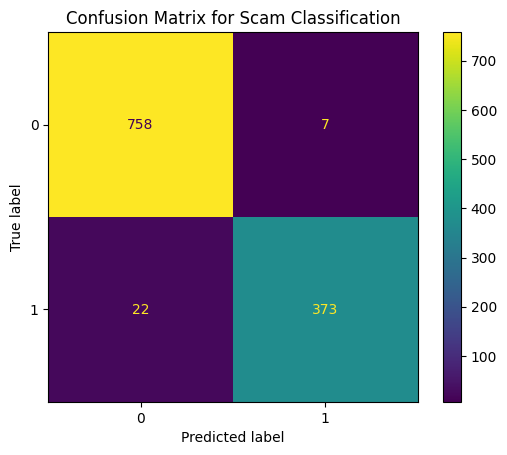

Test Loss: 0.2961, Test Accuracy: 0.9750, F1: 0.9626, ROC-AUC: 0.9931  (thresh 0.55)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'NYC done Peanut the Squirrel the same as Harambe #DoOnlyGoodEveryday to all creatures, great and small'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'Decentralized, as always.  Although the simple one-click yield might remind you of the old CEX days, this new feature is just as decentralized as any on-chain transactions.'}
False pos: {'coin_name': 'PEPE', 'label': 0, 'text': 'We are the media now'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'You got a friend in me'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': '<url>'}
False neg: {'coin_

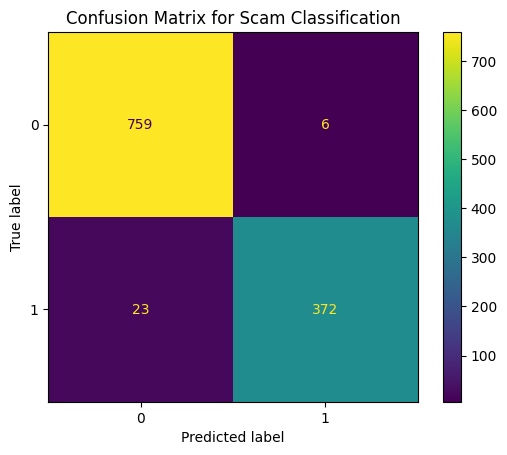

Test Loss: 0.2961, Test Accuracy: 0.9750, F1: 0.9625, ROC-AUC: 0.9931  (thresh 0.60)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'NYC done Peanut the Squirrel the same as Harambe #DoOnlyGoodEveryday to all creatures, great and small'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'Decentralized, as always.  Although the simple one-click yield might remind you of the old CEX days, this new feature is just as decentralized as any on-chain transactions.'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'You got a friend in me'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': '<url>'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'I am the hope of the universe'}
False neg

Test Loss: 0.2961, Test Accuracy: 0.9750, F1: 0.9624, ROC-AUC: 0.9931  (thresh 0.65)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'NYC done Peanut the Squirrel the same as Harambe #DoOnlyGoodEveryday to all creatures, great and small'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'Decentralized, as always.  Although the simple one-click yield might remind you of the old CEX days, this new feature is just as decentralized as any on-chain transactions.'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'You got a friend in me'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': '<url>'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'I am the hope of the universe'}
False neg

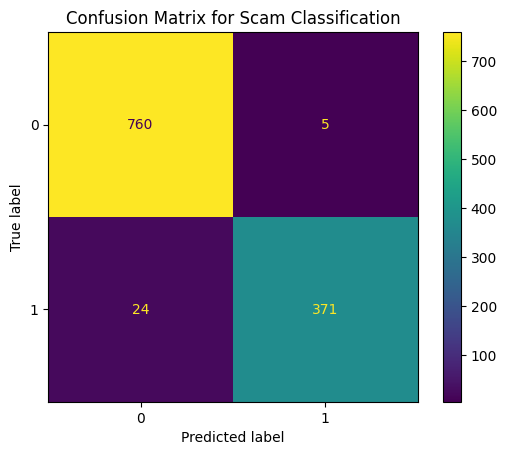

Test Loss: 0.2961, Test Accuracy: 0.9750, F1: 0.9624, ROC-AUC: 0.9931  (thresh 0.70)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'NYC done Peanut the Squirrel the same as Harambe #DoOnlyGoodEveryday to all creatures, great and small'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'Decentralized, as always.  Although the simple one-click yield might remind you of the old CEX days, this new feature is just as decentralized as any on-chain transactions.'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'You got a friend in me'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': '<url>'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'I am the hope of the universe'}
False neg

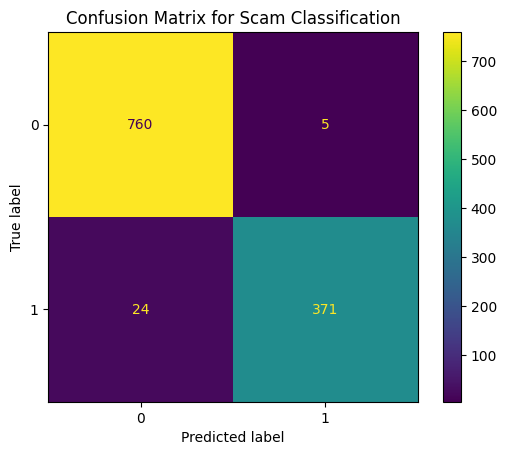

Test Loss: 0.2961, Test Accuracy: 0.9750, F1: 0.9624, ROC-AUC: 0.9931  (thresh 0.75)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'NYC done Peanut the Squirrel the same as Harambe #DoOnlyGoodEveryday to all creatures, great and small'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'Decentralized, as always.  Although the simple one-click yield might remind you of the old CEX days, this new feature is just as decentralized as any on-chain transactions.'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'You got a friend in me'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': '<url>'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'I am the hope of the universe'}
False neg

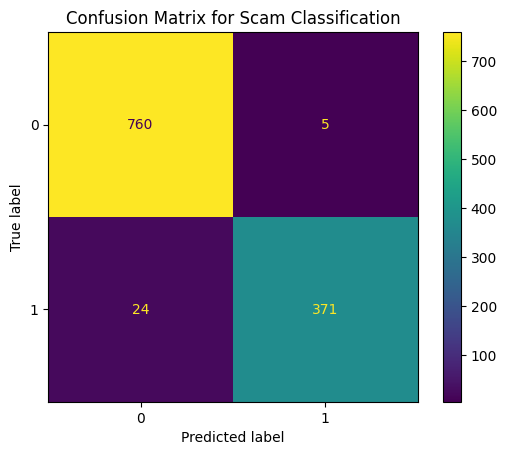

Test Loss: 0.2961, Test Accuracy: 0.9750, F1: 0.9624, ROC-AUC: 0.9931  (thresh 0.80)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'NYC done Peanut the Squirrel the same as Harambe #DoOnlyGoodEveryday to all creatures, great and small'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'Decentralized, as always.  Although the simple one-click yield might remind you of the old CEX days, this new feature is just as decentralized as any on-chain transactions.'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'You got a friend in me'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': '<url>'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'I am the hope of the universe'}
False neg

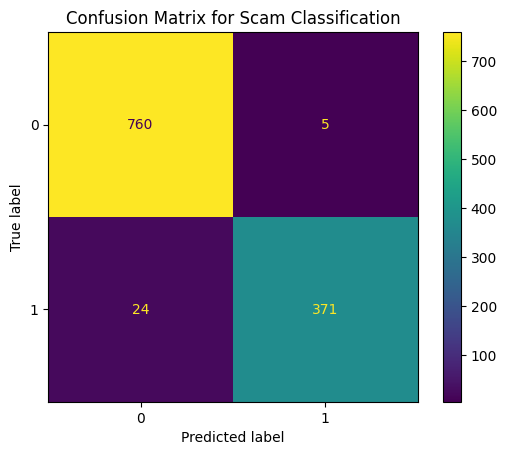

Test Loss: 0.2961, Test Accuracy: 0.9750, F1: 0.9624, ROC-AUC: 0.9931  (thresh 0.85)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'NYC done Peanut the Squirrel the same as Harambe #DoOnlyGoodEveryday to all creatures, great and small'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'Decentralized, as always.  Although the simple one-click yield might remind you of the old CEX days, this new feature is just as decentralized as any on-chain transactions.'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'You got a friend in me'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': '<url>'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'I am the hope of the universe'}
False neg

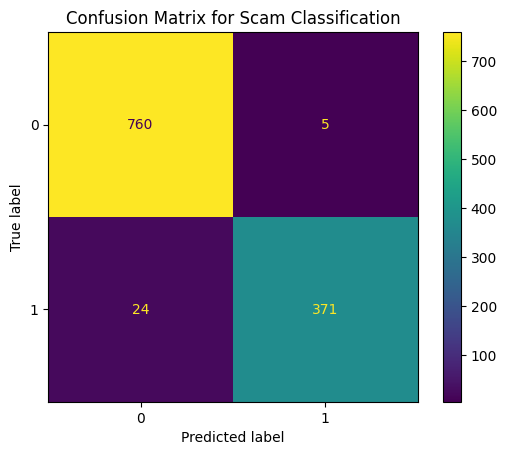

Test Loss: 0.2961, Test Accuracy: 0.9750, F1: 0.9624, ROC-AUC: 0.9931  (thresh 0.90)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False pos: {'coin_name': 'DOGE', 'label': 0, 'text': 'NYC done Peanut the Squirrel the same as Harambe #DoOnlyGoodEveryday to all creatures, great and small'}
False neg: {'coin_name': 'PARA', 'label': 1, 'text': 'Decentralized, as always.  Although the simple one-click yield might remind you of the old CEX days, this new feature is just as decentralized as any on-chain transactions.'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'You got a friend in me'}
False pos: {'coin_name': 'SPX', 'label': 0, 'text': '<url>'}
False neg: {'coin_name': 'PNUT', 'label': 1, 'text': 'I am the hope of the universe'}
False neg

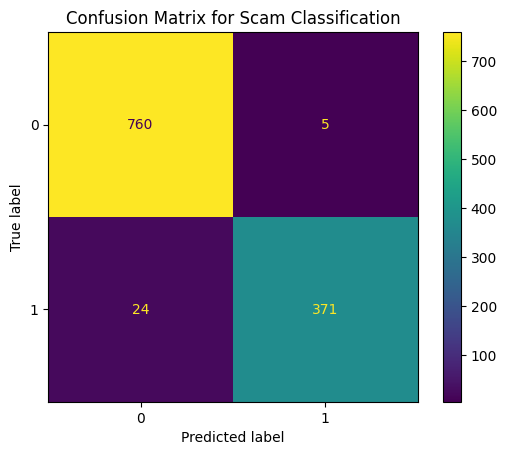

Test Loss: 0.2961, Test Accuracy: 0.9750, F1: 0.9624, ROC-AUC: 0.9931  (thresh 0.95)
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Enjoy the weekend'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Apple has been found to fund the majority of  @actonline , an astroturf group pretending to represent the needs of developers. Deceitful conduct from  @Apple  and ACT’s CEO  @morganwreed  which does active harm to developers worldwide.'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Congratulations to the  @OlympusDAO  team and  @ohmzeus  - excited to see this new architecture in action  There are a few major pieces to this release: the core registry (Kernel), treasury, minter, governor, and finally, the range-bound stability (RBS) system, which was written about by @ohmzeus early this year (<url> and developed by the stallion @oightytag.'}
False neg: {'coin_name': 'FOLD', 'label': 1, 'text': 'Introducing AVS Compression: The future of restaking efficiency! ReStake onc

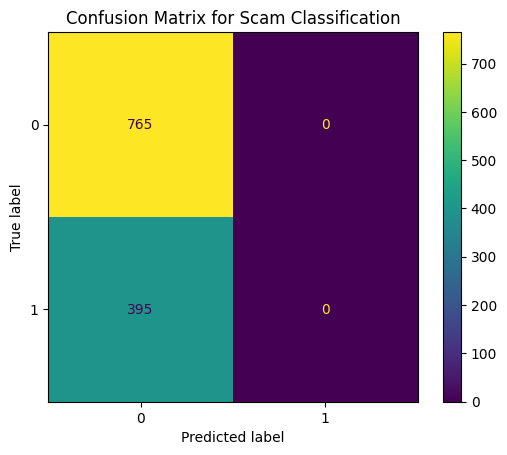

Test Loss: 0.2961, Test Accuracy: 0.6595, F1: 0.0000, ROC-AUC: 0.9931  (thresh 1.00)


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt


def evaluate_model(model, test_data, criterion, threshold):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    all_tweets = []

    with torch.no_grad():
        for batch in test_data:
            inputs, labels, attn_masks, tweets = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            attn_masks = attn_masks.to(device)
            all_tweets.extend(tweets)

            #roc-auc
            outputs = model(inputs, attn_masks)
            probs = torch.sigmoid(outputs.squeeze())
            all_probs.extend(probs.cpu().numpy())

            loss = criterion(outputs.squeeze(), labels.float())
            total_loss += loss.item()
            preds = torch.sigmoid(outputs.squeeze())
            preds = (preds > threshold).long()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_data)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    for i, pred in enumerate(all_preds):
      if pred != all_labels[i]:
        if all_labels[i] == 1:
          print(f"False neg: {all_tweets[i]}")
        if all_labels[i] == 0:
          print(f"False pos: {all_tweets[i]}")

    fscore = f1_score(np.array(all_labels), np.array(all_preds))
    roc_auc = roc_auc_score(np.array(all_labels), np.array(all_probs))
    cm = confusion_matrix(all_labels, all_preds)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
    cm_display.plot()
    plt.title("Confusion Matrix for Scam Classification")
    plt.show()

    return avg_loss, accuracy, fscore, roc_auc

print("Edge cases:")
test_loss, test_accuracy, test_fscore, roc_auc = evaluate_model(model, test_data, criterion, 1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1: {test_fscore:.4f}, ROC-AUC: {roc_auc:.4f} (thresh 1)")
test_loss, test_accuracy, test_fscore, roc_auc = evaluate_model(model, test_data, criterion, 0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1: {test_fscore:.4f}, ROC-AUC: {roc_auc:.4f}  (thresh 0)")

print("Reasonable thresholds:")
for threshold in np.linspace(0, 1, 21):
    test_loss, test_accuracy, test_fscore, roc_auc = evaluate_model(model, test_data, criterion, threshold)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1: {test_fscore:.4f}, ROC-AUC: {roc_auc:.4f}  (thresh {threshold:.2f})")

Zero Shot on MAP (to ensure that it's not just assuming memecoins are good)

In [ ]:
from google.colab import drive


drive.mount('/content/drive')

%cd /content/drive/MyDrive/CS257/masked_coins


!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CS257/masked_coins
ANUBIS_masked_tweets.json   FOLD_masked_tweets.json  PNUT_masked_tweets.json
BALD_masked_tweets.json     GIGA_masked_tweets.json  SHIB_masked_tweets.json
DEFI100_masked_tweets.json  MAP_masked_tweets.json   SPX_masked_tweets.json
DOGE_masked_tweets.json     OC_masked_tweets.json    THODEX_masked_tweets.json
ETH_masked_tweets.json	    PARA_masked_tweets.json  WIF_masked_tweets.json
FART_masked_tweets.json     PEPE_masked_tweets.json


In [ ]:
import json

def load_and_label(filenames: List[str], label: int) -> List[dict]:
    """Load tweets from a list of JSON filenames and assign the given label to each tweet.

    Args:
        filenames: List of file paths.
        label: The label to assign (e.g., 1 for scam, 0 for legit).

    Returns:
        A list of tweet dictionaries with the added 'label' key.
    """
    all_tweets = []
    for filename in filenames:
        with open(filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
        for tweet in data:
            tweet['label'] = label
        all_tweets.extend(data)
    return all_tweets

scam_files = ["DEFI100_masked_tweets.json",
              "BALD_masked_tweets.json",
              "ANUBIS_masked_tweets.json",
              "FOLD_masked_tweets.json",
              "OC_masked_tweets.json",
              "PARA_masked_tweets.json",
              "PNUT_masked_tweets.json",
              "THODEX_masked_tweets.json"]

legit_files = ["DOGE_masked_tweets.json",
               "FART_masked_tweets.json",
               "GIGA_masked_tweets.json",
               "PEPE_masked_tweets.json",
               "SHIB_masked_tweets.json",
               "SPX_masked_tweets.json",
               "WIF_masked_tweets.json"]

scam_test_files = ["MAP_masked_tweets.json"]
torch.cuda.empty_cache()
import gc
gc.collect()
scam_tweets = load_and_label(scam_files, label=1)
legit_tweets = load_and_label(legit_files, label=0)
all_tweets = scam_tweets + legit_tweets
train_tweets = all_tweets
test_tweets = load_and_label(scam_test_files, label=1)
train_embeddings = InputFormatter(config, train_tweets)
test_embeddings = InputFormatter(config, test_tweets)
print("Train xdata shape:", train_embeddings.xdata.shape)
print("Test xdata shape:", test_embeddings.xdata.shape)
train_data = [(train_embeddings.xdata, train_embeddings.ydata, train_embeddings.attn_masks)]
test_data = [(test_embeddings.xdata, test_embeddings.ydata, test_embeddings.attn_masks)]


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Train xdata shape: torch.Size([5758, 200])
Test xdata shape: torch.Size([39, 200])


In [ ]:

from torch.utils.data import TensorDataset, DataLoader


batch_size = 32

train_dataset = TensorDataset(train_embeddings.xdata, train_embeddings.ydata, train_embeddings.attn_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
config = SCConfig(block_size=200, drop_rate=0.3, nhid=768, nlayers=2, decoder_layers=1)
model = ScamClassifier(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
training_config = TrainingConfig(epochs=10, optimizer=optimizer, criterion=criterion)

def train_one_epoch(epoch: int, model, train_loader, training_config, clip: float) -> float:
    model.train()
    total_loss = 0.0
    for inputs, labels, attn_masks in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        attn_masks = attn_masks.to(device)

        training_config.optimizer.zero_grad()
        outputs = model(inputs, attn_masks)
        loss = training_config.criterion(outputs.squeeze(), labels.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        training_config.optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")
    return avg_loss

def train_model(model, train_loader, training_config, clip: float):
    for epoch in range(1, training_config.epochs + 1):
        train_one_epoch(epoch, model, train_loader, training_config, clip)

train_model(model, train_loader, training_config, clip=1.0)

Epoch 1: Loss = 0.0764
Epoch 2: Loss = 0.0349
Epoch 3: Loss = 0.0241
Epoch 4: Loss = 0.0222
Epoch 5: Loss = 0.0179
Epoch 6: Loss = 0.0181
Epoch 7: Loss = 0.0114
Epoch 8: Loss = 0.0216
Epoch 9: Loss = 0.0118
Epoch 10: Loss = 0.0168


In [ ]:
def evaluate_model(model, test_data, criterion, threshold):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_data:
            inputs, labels, attn_masks = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            attn_masks = attn_masks.to(device)

            outputs = model(inputs, attn_masks)
            loss = criterion(outputs.squeeze(), labels.float())
            total_loss += loss.item()
            preds = torch.sigmoid(outputs.squeeze())
            #decision threshold
            # print(f"preds: {preds}")
            preds = (preds > threshold).long()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_data)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    return avg_loss, accuracy
print("Edge cases:")
test_loss, test_accuracy = evaluate_model(model, test_data, criterion, 1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f} (thresh 1)")
test_loss, test_accuracy = evaluate_model(model, test_data, criterion, 0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f} (thresh 0)")
print("Reasonable thresholds:")
for threshold in range(0, 20):
  threshold /= 20.0
  test_loss, test_accuracy = evaluate_model(model, test_data, criterion, threshold)
  print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f} (thresh {threshold})")

Edge cases:
Test Loss: 2.4316, Test Accuracy: 0.0000 (thresh 1)
Test Loss: 2.4316, Test Accuracy: 1.0000 (thresh 0)
Reasonable thresholds:
Test Loss: 2.4316, Test Accuracy: 1.0000 (thresh 0.0)
Test Loss: 2.4316, Test Accuracy: 0.8718 (thresh 0.05)
Test Loss: 2.4316, Test Accuracy: 0.8718 (thresh 0.1)
Test Loss: 2.4316, Test Accuracy: 0.8718 (thresh 0.15)
Test Loss: 2.4316, Test Accuracy: 0.8718 (thresh 0.2)
Test Loss: 2.4316, Test Accuracy: 0.8718 (thresh 0.25)
Test Loss: 2.4316, Test Accuracy: 0.8718 (thresh 0.3)
Test Loss: 2.4316, Test Accuracy: 0.8718 (thresh 0.35)
Test Loss: 2.4316, Test Accuracy: 0.8718 (thresh 0.4)
Test Loss: 2.4316, Test Accuracy: 0.8718 (thresh 0.45)
Test Loss: 2.4316, Test Accuracy: 0.8718 (thresh 0.5)
Test Loss: 2.4316, Test Accuracy: 0.8718 (thresh 0.55)
Test Loss: 2.4316, Test Accuracy: 0.8718 (thresh 0.6)
Test Loss: 2.4316, Test Accuracy: 0.8718 (thresh 0.65)
Test Loss: 2.4316, Test Accuracy: 0.8718 (thresh 0.7)
Test Loss: 2.4316, Test Accuracy: 0.8718 (th

Alternative Pooling Functions

In [ ]:
from google.colab import drive


drive.mount('/content/drive')


%cd /content/drive/MyDrive/CS257/masked_coins


!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CS257/masked_coins
ANUBIS_masked_tweets.json   FOLD_masked_tweets.json  PNUT_masked_tweets.json
BALD_masked_tweets.json     GIGA_masked_tweets.json  SHIB_masked_tweets.json
DEFI100_masked_tweets.json  MAP_masked_tweets.json   SPX_masked_tweets.json
DOGE_masked_tweets.json     OC_masked_tweets.json    THODEX_masked_tweets.json
ETH_masked_tweets.json	    PARA_masked_tweets.json  WIF_masked_tweets.json
FART_masked_tweets.json     PEPE_masked_tweets.json


In [ ]:
import json

def load_and_label(filenames: List[str], label: int) -> List[dict]:
    """Load tweets from a list of JSON filenames and assign the given label to each tweet.

    Args:
        filenames: List of file paths.
        label: The label to assign (e.g., 1 for scam, 0 for legit).

    Returns:
        A list of tweet dictionaries with the added 'label' key.
    """
    all_tweets = []
    for filename in filenames:
        with open(filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
        for tweet in data:
            tweet['label'] = label
        all_tweets.extend(data)
    return all_tweets

scam_files = ["DEFI100_masked_tweets.json",
              "BALD_masked_tweets.json",
              "ANUBIS_masked_tweets.json",
              "FOLD_masked_tweets.json",
              "MAP_masked_tweets.json",
              "OC_masked_tweets.json",
              "PARA_masked_tweets.json",
              "PNUT_masked_tweets.json",
              "THODEX_masked_tweets.json"]

legit_files = ["DOGE_masked_tweets.json",
               "FART_masked_tweets.json",
              #  "ETH_masked_tweets.json",
               "GIGA_masked_tweets.json",
               "PEPE_masked_tweets.json",
               "SHIB_masked_tweets.json",
               "SPX_masked_tweets.json",
               "WIF_masked_tweets.json"]
torch.cuda.empty_cache()
import gc
gc.collect()
scam_tweets = load_and_label(scam_files, label=1)
legit_tweets = load_and_label(legit_files, label=0)
all_tweets = scam_tweets + legit_tweets
import random
random.shuffle(all_tweets)
split_idx = int(0.8 * len(all_tweets))
train_tweets = all_tweets[:split_idx]
test_tweets = all_tweets[split_idx:]
train_embeddings = InputFormatter(config, train_tweets)
test_embeddings = InputFormatter(config, test_tweets)
print("Train xdata shape:", train_embeddings.xdata.shape)
print("Test xdata shape:", test_embeddings.xdata.shape)
train_data = [(train_embeddings.xdata, train_embeddings.ydata, train_embeddings.attn_masks)]
test_data = [(test_embeddings.xdata, test_embeddings.ydata, test_embeddings.attn_masks)]


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Train xdata shape: torch.Size([4637, 200])
Test xdata shape: torch.Size([1160, 200])


In [ ]:

from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

train_dataset = TensorDataset(train_embeddings.xdata, train_embeddings.ydata, train_embeddings.attn_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
config = SCConfig(block_size=200, drop_rate=0.3, nhid=768, nlayers=2, decoder_layers=1)
model = ScamClassifierMaxPooling(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
training_config = TrainingConfig(epochs=10, optimizer=optimizer, criterion=criterion)

def train_one_epoch(epoch: int, model, train_loader, training_config, clip: float) -> float:
    model.train()
    total_loss = 0.0
    for inputs, labels, attn_masks in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        attn_masks = attn_masks.to(device)

        training_config.optimizer.zero_grad()
        outputs = model(inputs, attn_masks)
        loss = training_config.criterion(outputs.squeeze(), labels.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        training_config.optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")
    return avg_loss

def train_model(model, train_loader, training_config, clip: float):
    for epoch in range(1, training_config.epochs + 1):
        train_one_epoch(epoch, model, train_loader, training_config, clip)

train_model(model, train_loader, training_config, clip=1.0)

Epoch 1: Loss = 0.3815
Epoch 2: Loss = 0.1205
Epoch 3: Loss = 0.0357
Epoch 4: Loss = 0.0273
Epoch 5: Loss = 0.0132
Epoch 6: Loss = 0.0114
Epoch 7: Loss = 0.0101
Epoch 8: Loss = 0.0134
Epoch 9: Loss = 0.0142
Epoch 10: Loss = 0.0103


Edge cases:


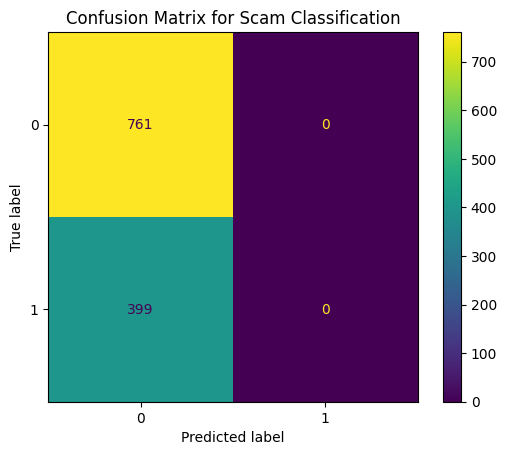

Test Loss: 0.6798, Test Accuracy: 0.6560, F1: 0.0000, ROC-AUC: 0.9370 (thresh 1)


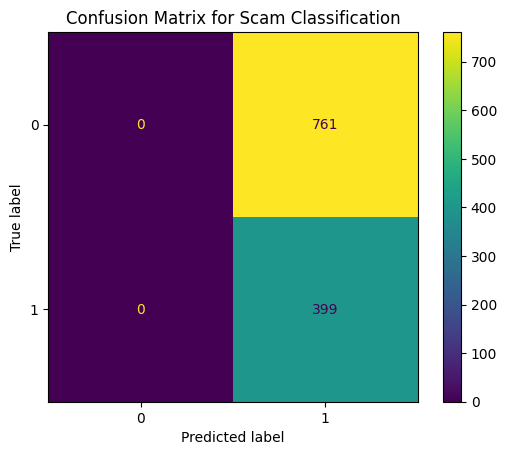

Test Loss: 0.6798, Test Accuracy: 0.3440, F1: 0.5119, ROC-AUC: 0.9370  (thresh 0)
Reasonable thresholds:


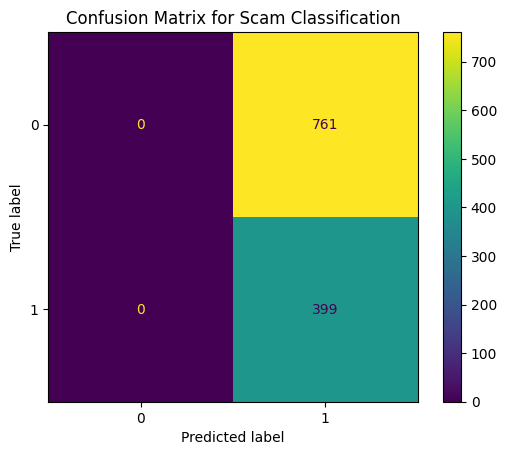

Test Loss: 0.6798, Test Accuracy: 0.3440, F1: 0.5119, ROC-AUC: 0.9370  (thresh 0.00)


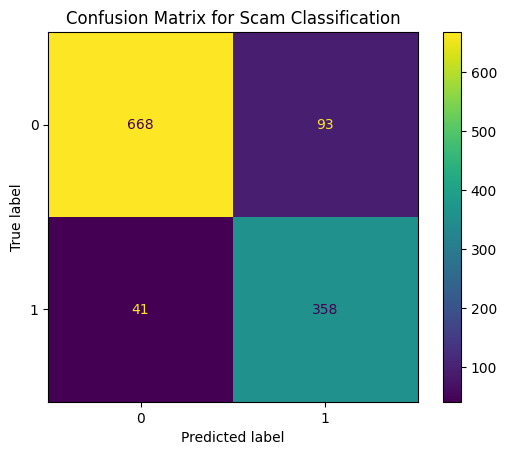

Test Loss: 0.6798, Test Accuracy: 0.8845, F1: 0.8424, ROC-AUC: 0.9370  (thresh 0.05)


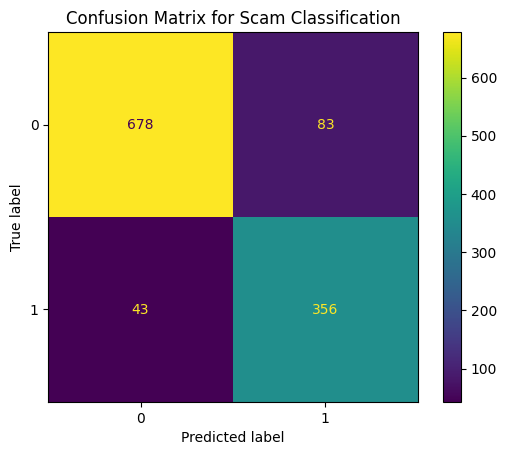

Test Loss: 0.6798, Test Accuracy: 0.8914, F1: 0.8496, ROC-AUC: 0.9370  (thresh 0.10)


Test Loss: 0.6798, Test Accuracy: 0.8966, F1: 0.8551, ROC-AUC: 0.9370  (thresh 0.15)


Test Loss: 0.6798, Test Accuracy: 0.8983, F1: 0.8568, ROC-AUC: 0.9370  (thresh 0.20)


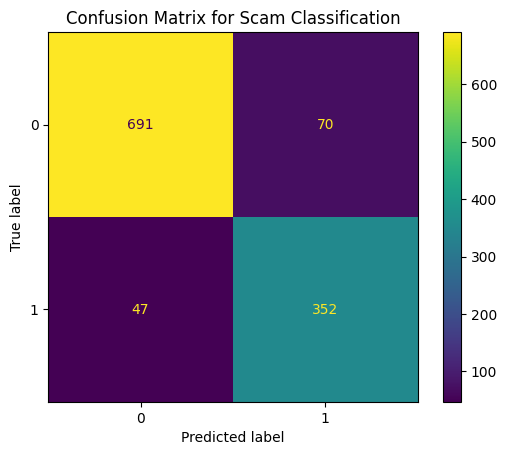

Test Loss: 0.6798, Test Accuracy: 0.8991, F1: 0.8575, ROC-AUC: 0.9370  (thresh 0.25)


Test Loss: 0.6798, Test Accuracy: 0.9034, F1: 0.8627, ROC-AUC: 0.9370  (thresh 0.30)


Test Loss: 0.6798, Test Accuracy: 0.9017, F1: 0.8600, ROC-AUC: 0.9370  (thresh 0.35)


Test Loss: 0.6798, Test Accuracy: 0.9017, F1: 0.8596, ROC-AUC: 0.9370  (thresh 0.40)


Test Loss: 0.6798, Test Accuracy: 0.9000, F1: 0.8568, ROC-AUC: 0.9370  (thresh 0.45)


Test Loss: 0.6798, Test Accuracy: 0.9000, F1: 0.8568, ROC-AUC: 0.9370  (thresh 0.50)


Test Loss: 0.6798, Test Accuracy: 0.9009, F1: 0.8575, ROC-AUC: 0.9370  (thresh 0.55)


Test Loss: 0.6798, Test Accuracy: 0.9043, F1: 0.8618, ROC-AUC: 0.9370  (thresh 0.60)


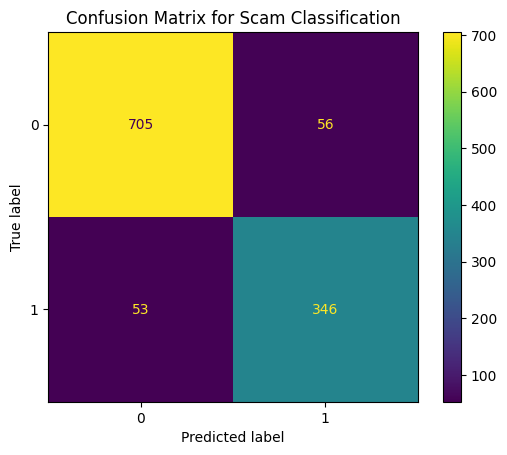

Test Loss: 0.6798, Test Accuracy: 0.9060, F1: 0.8639, ROC-AUC: 0.9370  (thresh 0.65)


Test Loss: 0.6798, Test Accuracy: 0.9086, F1: 0.8672, ROC-AUC: 0.9370  (thresh 0.70)


Test Loss: 0.6798, Test Accuracy: 0.9060, F1: 0.8629, ROC-AUC: 0.9370  (thresh 0.75)


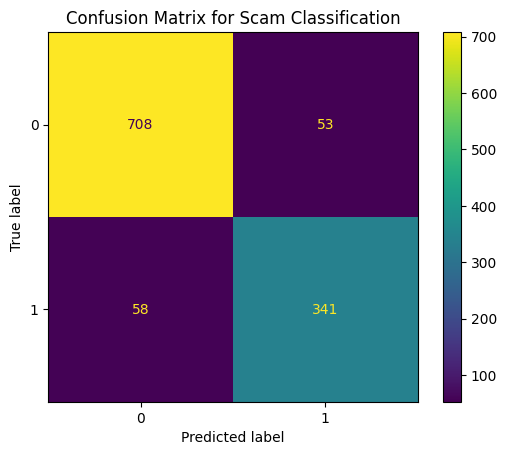

Test Loss: 0.6798, Test Accuracy: 0.9043, F1: 0.8600, ROC-AUC: 0.9370  (thresh 0.80)


Test Loss: 0.6798, Test Accuracy: 0.9060, F1: 0.8622, ROC-AUC: 0.9370  (thresh 0.85)


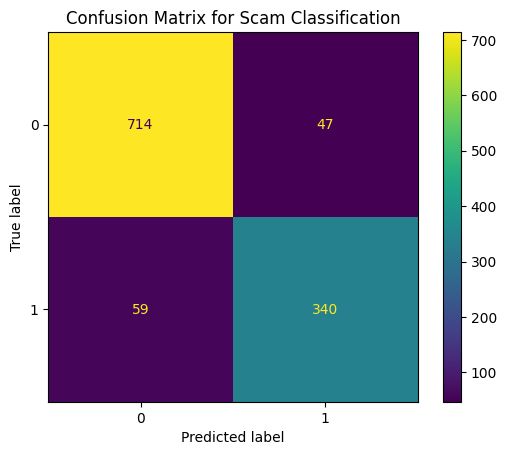

Test Loss: 0.6798, Test Accuracy: 0.9086, F1: 0.8651, ROC-AUC: 0.9370  (thresh 0.90)


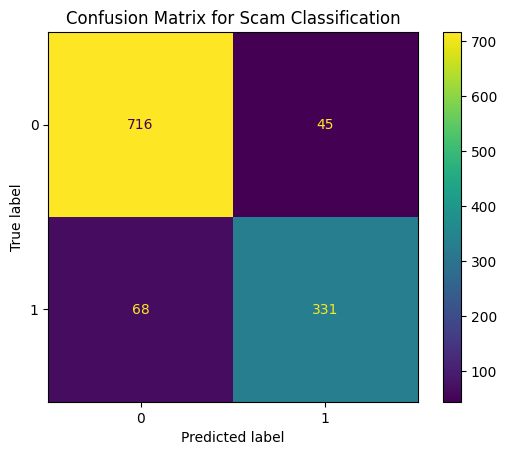

Test Loss: 0.6798, Test Accuracy: 0.9026, F1: 0.8542, ROC-AUC: 0.9370  (thresh 0.95)


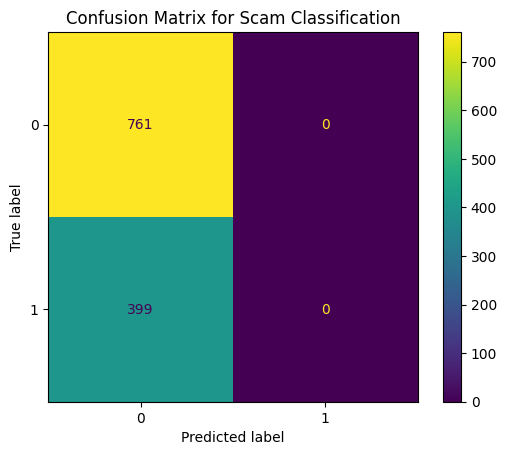

Test Loss: 0.6798, Test Accuracy: 0.6560, F1: 0.0000, ROC-AUC: 0.9370  (thresh 1.00)


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt


def evaluate_model(model, test_data, criterion, threshold):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in test_data:
            inputs, labels, attn_masks = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            attn_masks = attn_masks.to(device)

            #roc-auc
            outputs = model(inputs, attn_masks)
            probs = torch.sigmoid(outputs.squeeze())
            all_probs.extend(probs.cpu().numpy())

            outputs = model(inputs, attn_masks)
            loss = criterion(outputs.squeeze(), labels.float())
            total_loss += loss.item()
            preds = torch.sigmoid(outputs.squeeze())
            preds = (preds > threshold).long()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_data)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    fscore = f1_score(np.array(all_labels), np.array(all_preds))
    roc_auc = roc_auc_score(np.array(all_labels), np.array(all_probs))
    cm = confusion_matrix(all_labels, all_preds)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
    cm_display.plot()
    plt.title("Confusion Matrix for Scam Classification")
    plt.show()

    return avg_loss, accuracy, fscore, roc_auc

print("Edge cases:")
test_loss, test_accuracy, test_fscore, roc_auc = evaluate_model(model, test_data, criterion, 1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1: {test_fscore:.4f}, ROC-AUC: {roc_auc:.4f} (thresh 1)")
test_loss, test_accuracy, test_fscore, roc_auc = evaluate_model(model, test_data, criterion, 0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1: {test_fscore:.4f}, ROC-AUC: {roc_auc:.4f}  (thresh 0)")

print("Reasonable thresholds:")
for threshold in np.linspace(0, 1, 21):
    test_loss, test_accuracy, test_fscore, roc_auc = evaluate_model(model, test_data, criterion, threshold)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1: {test_fscore:.4f}, ROC-AUC: {roc_auc:.4f}  (thresh {threshold:.2f})")

Control Classifier (No Transformer)

In [ ]:
from google.colab import drive


drive.mount('/content/drive')

%cd /content/drive/MyDrive/CS257/coins

!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CS257/coins
ANUBIS_tweets.json   ETH_tweets.json   MAP_tweets.json	 PNUT_tweets.json    WIF_tweets.json
BALD_tweets.json     FART_tweets.json  OC_tweets.json	 SHIB_tweets.json
DEFI100_tweets.json  FOLD_tweets.json  PARA_tweets.json  SPX_tweets.json
DOGE_tweets.json     GIGA_tweets.json  PEPE_tweets.json  THODEX_tweets.json


In [ ]:
import json

def load_and_label(filenames: List[str], label: int) -> List[dict]:
    """Load tweets from a list of JSON filenames and assign the given label to each tweet.

    Args:
        filenames: List of file paths.
        label: The label to assign (e.g., 1 for scam, 0 for legit).

    Returns:
        A list of tweet dictionaries with the added 'label' key.
    """
    all_tweets = []
    for filename in filenames:
        with open(filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
        for tweet in data:
            tweet['label'] = label
        all_tweets.extend(data)
    return all_tweets

scam_files = ["DEFI100_tweets.json",
              "BALD_tweets.json",
              "ANUBIS_tweets.json",
              "FOLD_tweets.json",
              "MAP_tweets.json",
              "OC_tweets.json",
              "PARA_tweets.json",
              "PNUT_tweets.json",
              "THODEX_tweets.json"]
# legit_test_files = ["DOGE_tweets.json"]

legit_files = ["FART_tweets.json",
               "DOGE_tweets.json",
               "GIGA_tweets.json",
               "PEPE_tweets.json",
               "SHIB_tweets.json",
               "SPX_tweets.json",
               "WIF_tweets.json"]
torch.cuda.empty_cache()
import gc
gc.collect()
scam_tweets = load_and_label(scam_files, label=1)
legit_tweets = load_and_label(legit_files, label=0)
all_tweets = scam_tweets + legit_tweets
train_tweets = all_tweets
# test_tweets = load_and_label(legit_test_files, label=0)
# train_embeddings = InputFormatter(config, train_tweets)
# test_embeddings = InputFormatter(config, test_tweets)
import random
random.shuffle(all_tweets)
split_idx = int(0.8 * len(all_tweets))
train_tweets = all_tweets[:split_idx]
test_tweets = all_tweets[split_idx:]
train_embeddings = InputFormatter(config, train_tweets)
test_embeddings = InputFormatter(config, test_tweets)
print("Train xdata shape:", train_embeddings.xdata.shape)
print("Test xdata shape:", test_embeddings.xdata.shape)
train_data = [(train_embeddings.xdata, train_embeddings.ydata)]
test_data = [(test_embeddings.xdata, test_embeddings.ydata)]


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Train xdata shape: torch.Size([4637, 200])
Test xdata shape: torch.Size([1160, 200])


In [ ]:

from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

train_dataset = TensorDataset(train_embeddings.xdata, train_embeddings.ydata)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
config = SCConfig(block_size=200, drop_rate=0.3, nhid=768, nlayers=2, decoder_layers=1)
model = SCControl(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
training_config = TrainingConfig(epochs=10, optimizer=optimizer, criterion=criterion)

def train_one_epoch(epoch: int, model, train_loader, training_config, clip: float) -> float:
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        training_config.optimizer.zero_grad()
        outputs = model(inputs)
        loss = training_config.criterion(outputs.squeeze(), labels.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        training_config.optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")
    return avg_loss

def train_model(model, train_loader, training_config, clip: float):
    for epoch in range(1, training_config.epochs + 1):
        train_one_epoch(epoch, model, train_loader, training_config, clip)


train_model(model, train_loader, training_config, clip=1.0)

Epoch 1: Loss = 0.2406
Epoch 2: Loss = 0.0289
Epoch 3: Loss = 0.0196
Epoch 4: Loss = 0.0114
Epoch 5: Loss = 0.0090
Epoch 6: Loss = 0.0079
Epoch 7: Loss = 0.0051
Epoch 8: Loss = 0.0099
Epoch 9: Loss = 0.0070
Epoch 10: Loss = 0.0047


Edge cases:


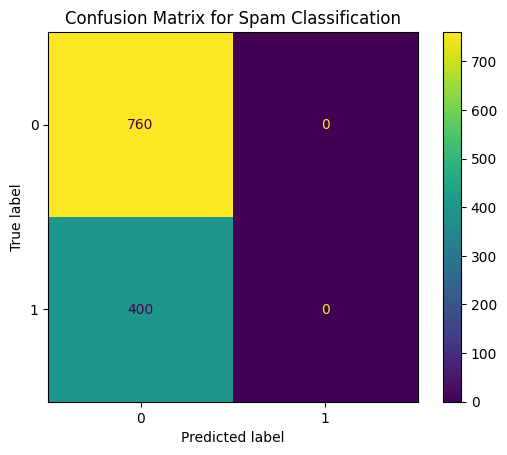

Test Loss: 0.0992, Test Accuracy: 0.6552, F1: 0.0000 (thresh 1)


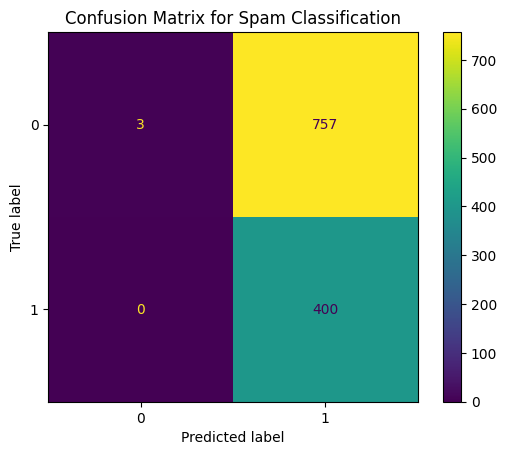

Test Loss: 0.0992, Test Accuracy: 0.3474, F1: 0.5138 (thresh 0)
Reasonable thresholds:


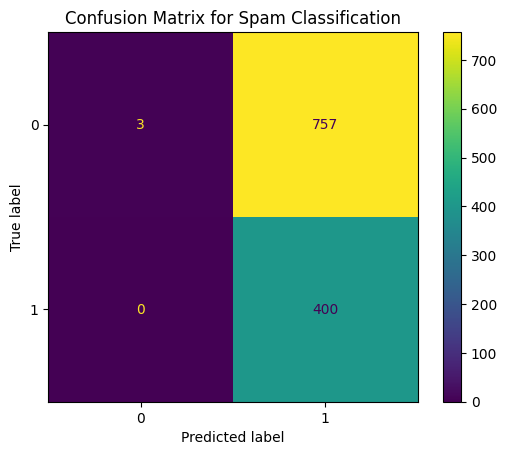

Test Loss: 0.0992, Test Accuracy: 0.3474, F1: 0.5138 (thresh 0.00)


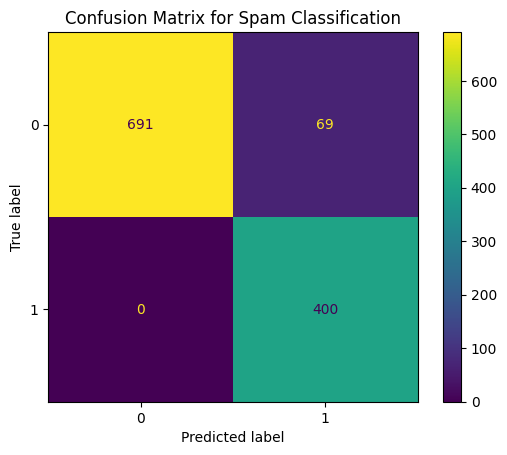

Test Loss: 0.0992, Test Accuracy: 0.9405, F1: 0.9206 (thresh 0.05)


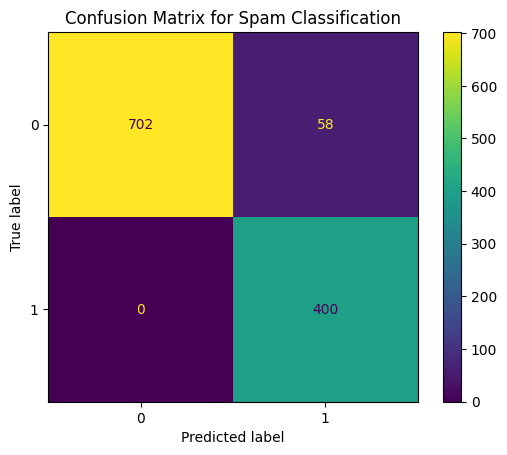

Test Loss: 0.0992, Test Accuracy: 0.9500, F1: 0.9324 (thresh 0.10)


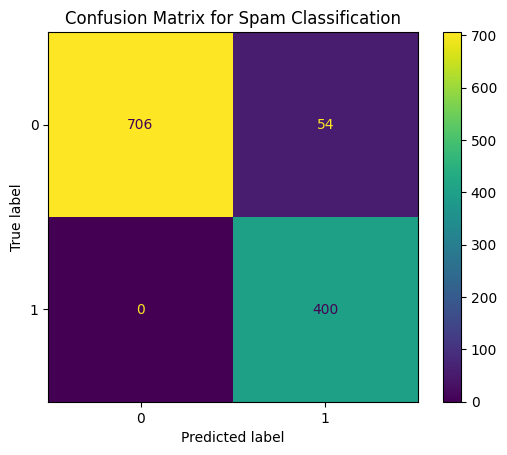

Test Loss: 0.0992, Test Accuracy: 0.9534, F1: 0.9368 (thresh 0.15)


Test Loss: 0.0992, Test Accuracy: 0.9560, F1: 0.9401 (thresh 0.20)


Test Loss: 0.0992, Test Accuracy: 0.9569, F1: 0.9410 (thresh 0.25)


Test Loss: 0.0992, Test Accuracy: 0.9586, F1: 0.9433 (thresh 0.30)


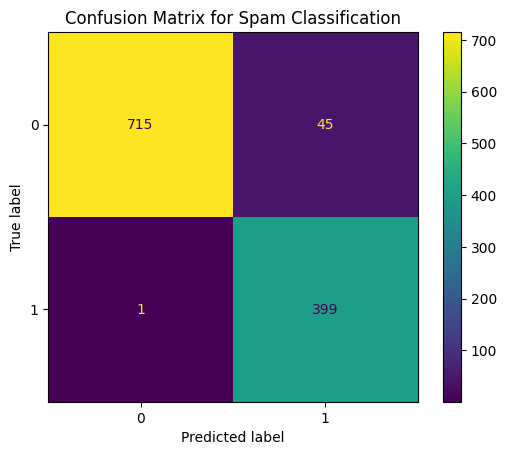

Test Loss: 0.0992, Test Accuracy: 0.9603, F1: 0.9455 (thresh 0.35)


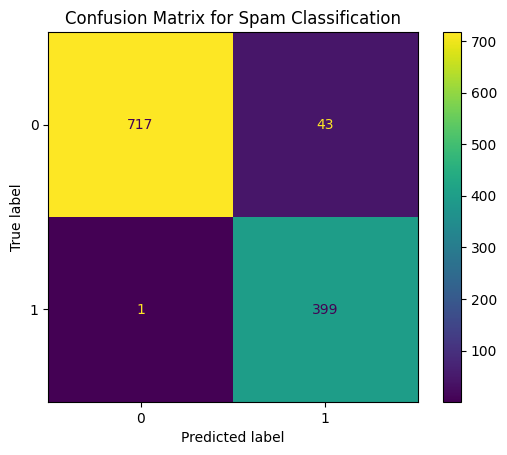

Test Loss: 0.0992, Test Accuracy: 0.9621, F1: 0.9477 (thresh 0.40)


Test Loss: 0.0992, Test Accuracy: 0.9638, F1: 0.9500 (thresh 0.45)


Test Loss: 0.0992, Test Accuracy: 0.9647, F1: 0.9510 (thresh 0.50)


Test Loss: 0.0992, Test Accuracy: 0.9672, F1: 0.9544 (thresh 0.55)


Test Loss: 0.0992, Test Accuracy: 0.9707, F1: 0.9590 (thresh 0.60)


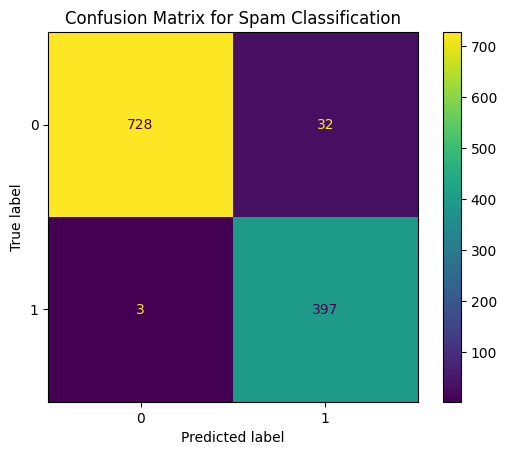

Test Loss: 0.0992, Test Accuracy: 0.9698, F1: 0.9578 (thresh 0.65)


Test Loss: 0.0992, Test Accuracy: 0.9716, F1: 0.9601 (thresh 0.70)


Test Loss: 0.0992, Test Accuracy: 0.9759, F1: 0.9659 (thresh 0.75)


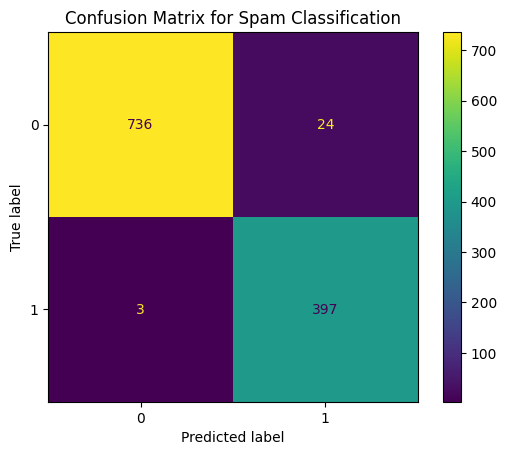

Test Loss: 0.0992, Test Accuracy: 0.9767, F1: 0.9671 (thresh 0.80)


Test Loss: 0.0992, Test Accuracy: 0.9776, F1: 0.9683 (thresh 0.85)


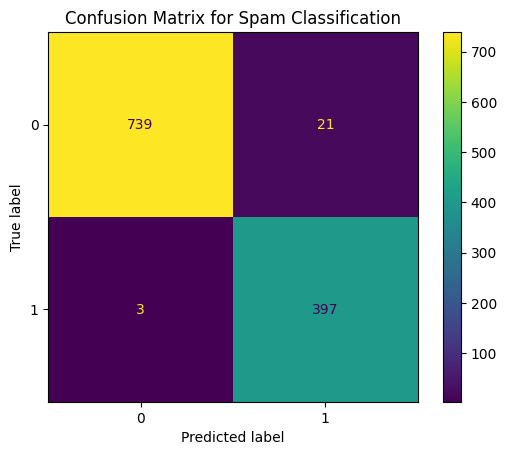

Test Loss: 0.0992, Test Accuracy: 0.9793, F1: 0.9707 (thresh 0.90)


Test Loss: 0.0992, Test Accuracy: 0.9836, F1: 0.9766 (thresh 0.95)


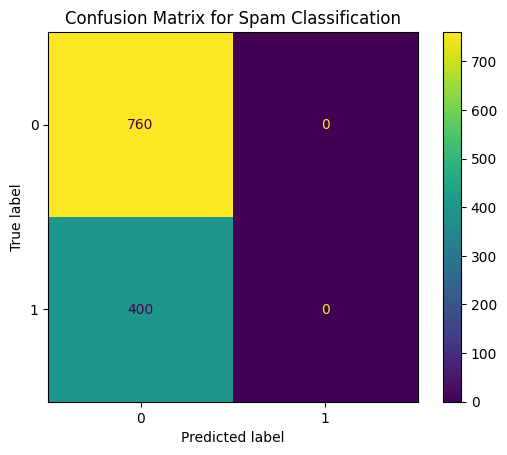

Test Loss: 0.0992, Test Accuracy: 0.6552, F1: 0.0000 (thresh 1.00)


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, test_data, criterion, threshold):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_data:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            total_loss += loss.item()
            preds = torch.sigmoid(outputs.squeeze())
            preds = (preds > threshold).long()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_data)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    fscore = f1_score(np.array(all_labels), np.array(all_preds))
    cm = confusion_matrix(all_labels, all_preds)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
    cm_display.plot()
    plt.title("Confusion Matrix for Spam Classification")
    plt.show()

    return avg_loss, accuracy, fscore

print("Edge cases:")
test_loss, test_accuracy, test_fscore = evaluate_model(model, test_data, criterion, 1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1: {test_fscore:.4f} (thresh 1)")
test_loss, test_accuracy, test_fscore = evaluate_model(model, test_data, criterion, 0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1: {test_fscore:.4f} (thresh 0)")

print("Reasonable thresholds:")
for threshold in np.linspace(0, 1, 21):
    test_loss, test_accuracy, test_fscore = evaluate_model(model, test_data, criterion, threshold)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1: {test_fscore:.4f} (thresh {threshold:.2f})")

## Alternative Baselines
Naive Bayes

BOWs Logistic Regression


### Naive Bayes


In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

bertweet = AutoModel.from_pretrained("vinai/bertweet-base")


tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

line = "SC has first two presumptive cases of coronavirus , DHEC confirms HTTPURL via @USER :cry:"
w_emojis = "I think we all know its Doge-chan! UwU; \u4eca\u5e74\u306e\u30b7\u30e3\u30ab\u30b7\u30e3\u30ab\u30dd\u30c6\u30c8\u00ae\u306f\u3053\u306e\u65b9\u304c\u767b\u5834\uff01Y"
wo_emojis = "\"not a memecoin\"  listen.. lean-in guys, you have that whole laser-eyes thing going on.. search your feelings you know it be true.  Bitcoin isn't a memecoin. <url>"

input_ids = torch.tensor([tokenizer.encode(w_emojis)])

with torch.no_grad():
    features = bertweet(input_ids)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [ ]:
tokenizer.decode(3)

'<unk>'

In [ ]:
import json

def load_and_label(filenames: list[str], label: int) -> list[dict]:
    """Load tweets from a list of JSON filenames and assign the given label to each tweet.

    Args:
        filenames: List of file paths.
        label: The label to assign (e.g., 1 for scam, 0 for legit).

    Returns:
        A list of tweet dictionaries with the added 'label' key.
    """
    all_tweets = []
    for filename in filenames:
        with open(filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
        for tweet in data:
            tweet['label'] = label
        all_tweets.extend(data)
    return all_tweets

scam_files = ["DEFI100_masked_tweets.json",
              "BALD_masked_tweets.json",
              "ANUBIS_masked_tweets.json",
              "FOLD_masked_tweets.json",
              "MAP_masked_tweets.json",
              "OC_masked_tweets.json",
              "PARA_masked_tweets.json",
              "PNUT_masked_tweets.json",
              "THODEX_masked_tweets.json"]
# legit_test_files = ["DOGE_tweets.json"]

legit_files = ["FART_masked_tweets.json",
               "DOGE_masked_tweets.json",
               "GIGA_masked_tweets.json",
               "PEPE_masked_tweets.json",
               "SHIB_masked_tweets.json",
               "SPX_masked_tweets.json",
               "WIF_masked_tweets.json"]
torch.cuda.empty_cache()
import gc
gc.collect()
scam_tweets = load_and_label(scam_files, label=1)
legit_tweets = load_and_label(legit_files, label=0)
all_tweets = scam_tweets + legit_tweets
train_tweets = all_tweets
# test_tweets = load_and_label(legit_test_files, label=0)
# train_embeddings = InputFormatter(config, train_tweets)
# test_embeddings = InputFormatter(config, test_tweets)
import random
random.shuffle(all_tweets)
split_idx = int(0.8 * len(all_tweets))
train_tweets = all_tweets[:split_idx]
test_tweets = all_tweets[split_idx:]
train_embeddings = InputFormatter(config, train_tweets)
test_embeddings = InputFormatter(config, test_tweets)
print("Train xdata shape:", train_embeddings.xdata.shape)
print("Test xdata shape:", test_embeddings.xdata.shape)
train_data = (train_embeddings.xdata, train_embeddings.ydata)
test_data = (test_embeddings.xdata, test_embeddings.ydata)


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Train xdata shape: torch.Size([4637, 200])
Test xdata shape: torch.Size([1160, 200])


In [ ]:
train_data[0].shape

torch.Size([4637, 200])

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

train_dataset = TensorDataset(train_embeddings.xdata, train_embeddings.ydata)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
config = SCConfig(block_size=200, drop_rate=0.3, nhid=768, nlayers=2, decoder_layers=1)

In [ ]:
class NaiveBayes:

  def __init__(self, tokenizer, tensordataset, smoothing = 1.0):
    self.tokenizer = tokenizer
    self.train = tensordataset
    self.vocab_size = tokenizer.vocab_size

    self.alpha = smoothing
    self.feature_counts = torch.zeros(2, tokenizer.vocab_size, dtype=torch.float)
    self.class_counts = torch.zeros(2, dtype=torch.float)

    self.log_class_prior = None      
    self.log_feature_prob = None    

  def train_nb(self):
    for i in range(self.train.tensors[0].shape[0]):
      x_vec = self.train.tensors[0][i]
      label = self.train.tensors[1][i]
      counts = torch.bincount(x_vec, minlength = self.vocab_size)
      counts[1] = 0
      self.feature_counts[label] += counts
      self.class_counts[label] += 1

    total_count = torch.sum(self.class_counts)
    self.log_class_prior = torch.log(self.class_counts + self.alpha) \
                            - torch.log(total_count + self.alpha*self.vocab_size)


    class_token_count = torch.sum(self.feature_counts, dim=1) 
    self.log_feature_prob = torch.log(self.feature_counts + self.alpha) \
                            - torch.log((class_token_count + self.alpha*self.vocab_size).unsqueeze(1))

  def predict(self, X: torch.Tensor) -> torch.Tensor:
      """
      Predict class labels for a batch of input features.

      :param X: A 2D Tensor of shape (batch_size, n_features)
      :return: A 1D Tensor of shape (batch_size,) with predicted class labels
      """
      log_class_prior_broadcast = self.log_class_prior.unsqueeze(0)  
      X = torch.tensor(np.array([torch.cat([t[:1], torch.tensor([0], device=t.device), t[2:]]) if len(t) > 1 else t for t in [torch.bincount(x, minlength = self.vocab_size) for x in X]]), dtype=torch.float32)
      log_posterior = X @ self.log_feature_prob.T + log_class_prior_broadcast
      return torch.argmax(log_posterior, dim=1)


  def predict_proba(self, X: torch.Tensor) -> torch.Tensor:
      """
      (Optional) Get the probability distribution p(class|X) for each sample.

      :param X: (batch_size, n_features)
      :return: (batch_size, n_classes) with probabilities summing to 1 across classes
      """
      log_class_prior_broadcast = self.log_class_prior.unsqueeze(0)  # (1, n_classes)
      log_posterior = X @ self.log_feature_prob.T + log_class_prior_broadcast
      return torch.softmax(log_posterior, dim=1)


In [ ]:
##Testing Naive Bayes

modelNB = NaiveBayes(tokenizer, train_dataset)
modelNB.train_nb()

In [ ]:
predictions = modelNB.predict(test_data[0])
predictions

tensor([0, 1, 0,  ..., 0, 0, 0])

Accuracy: 0.8991
F1-score: 0.8963
Confusion Matrix:


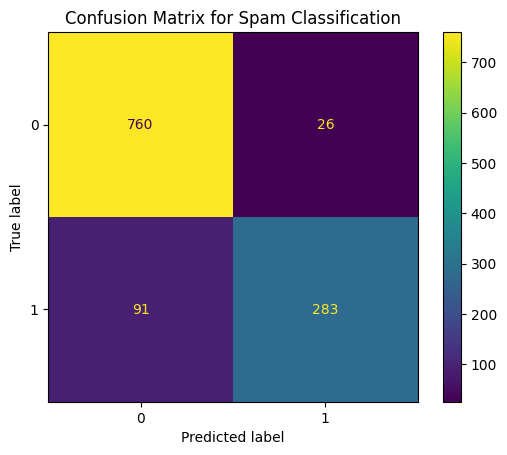

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def evaluate_predictions(y_true, y_pred):
    """
    Prints the accuracy, F1-score, and confusion matrix
    given arrays of ground truth labels (y_true) and predicted labels (y_pred).
    """


    y_true = np.array(y_true)
    y_pred = np.array(y_pred)


    acc = accuracy_score(y_true, y_pred)


    f1 = f1_score(y_true, y_pred, average="weighted")


    cm = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion Matrix:")

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

    cm_display.plot()
    plt.title("Confusion Matrix for Spam Classification")
    plt.show()

evaluate_predictions(test_data[1], predictions)

### Bag of Words Logistic Regression

In [ ]:

from sklearn.linear_model import LogisticRegression

X_train, y_train = train_data
X_test, y_test = test_data


logreg_model = LogisticRegression()


logreg_model.fit(X_train, y_train)

y_pred = logreg_model.predict(X_test)


from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy}")


from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='weighted') 
print(f"Logistic Regression F1 Score: {f1}")


Logistic Regression Accuracy: 0.6948275862068966
Logistic Regression F1 Score: 0.6140532707349937


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.linear_model import LogisticRegression

class BOWLogisticRegression:

  def __init__(self, tokenizer, tensordataset):
    self.tokenizer = tokenizer
    self.vocab_size = tokenizer.vocab_size

    self.log_reg = torch.nn.Linear(self.vocab_size, 1)
    self.activation = torch.nn.Sigmoid()

    self.train = tensordataset
    self.n_data = self.train.tensors[0].shape[0]
    self.X = torch.zeros(self.n_data, self.vocab_size)
    self.y = self.train.tensors[1]

    for i in range(self.n_data):
      x_vec = self.train.tensors[0][i]
      label = self.train.tensors[1][i]
      counts = torch.bincount(x_vec, minlength = self.vocab_size)
      counts[1] = 0
      self.X[i] = counts

    self.model = LogisticRegression()
    self.model.fit(self.X, self.y)

  def predict(self, Xtest):
    return self.model.predict(Xtest)

  def predict_proba(self, Xtest):
    return self.model.predict_proba(Xtest)

  # def forward(self, tensordataset):
  #   self.n_data = self.train.tensors[0].shape[0]
  #   self.X = torch.zeros(self.n_data, self.vocab_size)

  #   for i in range(self.n_data):
  #     x_vec = self.train.tensors[0][i]
  #     label = self.train.tensors[1][i]
  #     counts = torch.bincount(x_vec, minlength = self.vocab_size)
  #     self.X[i] = counts

  #   return self.activation(self.log_reg(self.X))

  # def standardLR(self):
  #   standardLR =


In [ ]:
bowLRmodel = BOWLogisticRegression(tokenizer, train_dataset)

Accuracy: 0.8957
F1-score: 0.8954
Confusion Matrix:


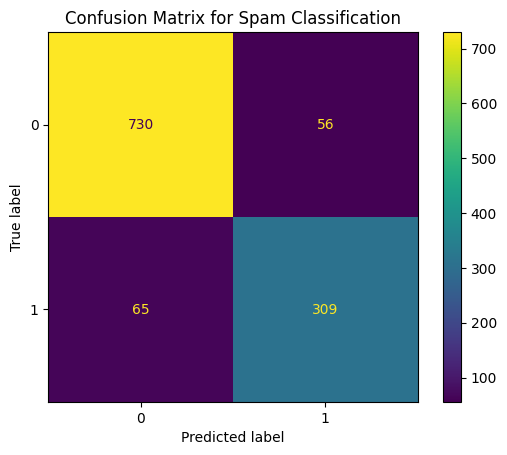

In [ ]:
new_test = torch.tensor(np.array([torch.cat([t[:1], torch.tensor([0], device=t.device), t[2:]]) if len(t) > 1 else t for t in [torch.bincount(x, minlength = tokenizer.vocab_size) for x in test_data[0]]]), dtype=torch.float32)

bowLRpred = bowLRmodel.predict(new_test)
evaluate_predictions(test_data[1], bowLRpred)

In [ ]:
sorted_coefs = np.argsort(-bowLRmodel.model.coef_)
sorted_coefs

array([[24862, 52073,   836, ..., 10575,  2470,  9644]])

In [ ]:
for i in range(100):
  print(f"The word {tokenizer.decode(sorted_coefs[0][i])} has coefficient {bowLRmodel.model.coef_[0][sorted_coefs[0][i]]}")

The word Peanut has coefficient 2.3155953658900574
The word lel has coefficient 2.2323079036526545
The word l@@ has coefficient 1.6226277334747898
The word Fi has coefficient 1.5031998716678534
The word ll@@ has coefficient 1.4141931418155262
The word peanut has coefficient 1.3127747513427592
The word #E@@ has coefficient 1.3003961058818847
The word el@@ has coefficient 1.2408043709843768
The word Squirrel has coefficient 1.2311897647629795
The word rel@@ has coefficient 1.1444788639102323
The word 的@@ has coefficient 1.1418444408943222
The word ev@@ has coefficient 1.1094852184873418
The word Nuts has coefficient 1.101619054050581
The word DOT has coefficient 1.0767397119466027
The word fight has coefficient 1.0720723110979316
The word squirrel has coefficient 1.0607049536413613
The word ME@@ has coefficient 1.0222336783662331
The word start has coefficient 0.9682837984004968
The word ance@@ has coefficient 0.9656569887792504
The word If has coefficient 0.964595450371171
The word nuts

In [ ]:
for i in range(100):
  print(f"The word {tokenizer.decode(sorted_coefs[0][-i-1])} has coefficient {bowLRmodel.model.coef_[0][sorted_coefs[0][-i-1]]}")

The word coin has coefficient -2.3191685792042125
The word hat has coefficient -2.112824756213288
The word 69@@ has coefficient -1.3927848059038428
The word stock has coefficient -1.3031349934970897
The word 00 has coefficient -1.2860355401372934
The word co@@ has coefficient -1.282674234060614
The word eon has coefficient -1.270834905433483
The word TRE@@ has coefficient -1.2125986979451642
The word memes has coefficient -1.1958796100382534
The word ES has coefficient -1.1763105570950054
The word dog has coefficient -1.0688047061091752
The word Gm has coefficient -1.0355304115637118
The word hat@@ has coefficient -1.0308618720987974
The word stays has coefficient -1.0183453377191065
The word Hat has coefficient -1.0143546196143778
The word mem@@ has coefficient -1.014049301874778
The word wow has coefficient -1.010389060192387
The word Ross has coefficient -0.9868890877242781
The word if has coefficient -0.94695776532726
The word &@@ has coefficient -0.9349357998515845
The word dog@@ 

### Transformer Decoder Ablation

In [ ]:
# class ScamClassifierDecoder(nn.Module):
#     def __init__(self, config):
#         super(ScamClassifierDecoder, self).__init__()
#         self.config = config
#         self.embedding = bertweet.embeddings.word_embeddings

#         # self.decoder = TransformerEncoderBlock(
#         #     d_model=config.nhid,
#         #     nhead=config.nlayers,
#         #     dropout=config.mlp_drop
#         # )

#         self.decoder = nn.TransformerDecoderLayer(d_model = config.nhid,
#                                                   nhead = config.nlayers,
#                                                   batch_first = True)

#         self.classifier = nn.Sequential(
#             nn.Linear(config.nhid, config.nhid // 2),
#             nn.ReLU(),
#             nn.Dropout(config.mlp_drop),
#             nn.Linear(config.nhid // 2, config.nhid // 4),
#             nn.ReLU(),
#             nn.Dropout(config.mlp_drop),
#             nn.Linear(config.nhid // 4, 1)
#         )

#     def forward(self, inputs, attention_mask):
#         embeds = self.embedding(inputs)
#         key_padding_mask = ~attention_mask
#         memory = torch.rand(200, 10, self.config.nhid).to(device)
#         x = self.decoder(embeds, memory)
#         x = x[-1]
#         logits = self.classifier(x)
#         return logits
class ScamClassifierDecoder(nn.Module):
    def __init__(self, config):
        super(ScamClassifierDecoder, self).__init__()
        self.config = config
        self.embedding = bertweet.embeddings.word_embeddings

        self.decoder = nn.TransformerDecoderLayer(
            d_model=config.nhid,
            nhead=config.nlayers,
            batch_first=True
        )

        self.classifier = nn.Sequential(
            nn.Linear(config.nhid, config.nhid // 2),
            nn.ReLU(),
            nn.Dropout(config.mlp_drop),
            nn.Linear(config.nhid // 2, config.nhid // 4),
            nn.ReLU(),
            nn.Dropout(config.mlp_drop),
            nn.Linear(config.nhid // 4, 1)
        )

    def forward(self, inputs, attention_mask):

        embeds = self.embedding(inputs)

        key_padding_mask = ~attention_mask

        batch_size = embeds.size(0)
        memory = torch.zeros(batch_size, 1, self.config.nhid, device=embeds.device)


        x = self.decoder(embeds, memory, tgt_key_padding_mask=key_padding_mask)


        x = x[:, -1, :]

        logits = self.classifier(x)
        return logits


In [ ]:
from google.colab import drive


drive.mount('/content/drive')

%cd /content/drive/MyDrive/CS257/masked_coins

!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CS257/masked_coins
ANUBIS_masked_tweets.json   FOLD_masked_tweets.json  PNUT_masked_tweets.json
BALD_masked_tweets.json     GIGA_masked_tweets.json  SHIB_masked_tweets.json
DEFI100_masked_tweets.json  MAP_masked_tweets.json   SPX_masked_tweets.json
DOGE_masked_tweets.json     OC_masked_tweets.json    THODEX_masked_tweets.json
ETH_masked_tweets.json	    PARA_masked_tweets.json  WIF_masked_tweets.json
FART_masked_tweets.json     PEPE_masked_tweets.json


In [ ]:
import json

def load_and_label(filenames: List[str], label: int) -> List[dict]:
    """Load tweets from a list of JSON filenames and assign the given label to each tweet.

    Args:
        filenames: List of file paths.
        label: The label to assign (e.g., 1 for scam, 0 for legit).

    Returns:
        A list of tweet dictionaries with the added 'label' key.
    """
    all_tweets = []
    for filename in filenames:
        with open(filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
        for tweet in data:
            tweet['label'] = label
        all_tweets.extend(data)
    return all_tweets

scam_files = ["DEFI100_masked_tweets.json",
              "BALD_masked_tweets.json",
              "ANUBIS_masked_tweets.json",
              "FOLD_masked_tweets.json",
              "MAP_masked_tweets.json",
              "OC_masked_tweets.json",
              "PARA_masked_tweets.json",
              "PNUT_masked_tweets.json",
              "THODEX_masked_tweets.json"]

legit_files = ["DOGE_masked_tweets.json",
               "FART_masked_tweets.json",
              #  "ETH_masked_tweets.json",
               "GIGA_masked_tweets.json",
               "PEPE_masked_tweets.json",
               "SHIB_masked_tweets.json",
               "SPX_masked_tweets.json",
               "WIF_masked_tweets.json"]
torch.cuda.empty_cache()
import gc
gc.collect()
scam_tweets = load_and_label(scam_files, label=1)
legit_tweets = load_and_label(legit_files, label=0)
all_tweets = scam_tweets + legit_tweets
import random
random.shuffle(all_tweets)
split_idx = int(0.8 * len(all_tweets))
train_tweets = all_tweets[:split_idx]
test_tweets = all_tweets[split_idx:]
train_embeddings = InputFormatter(config, train_tweets)
test_embeddings = InputFormatter(config, test_tweets)
print("Train xdata shape:", train_embeddings.xdata.shape)
print("Test xdata shape:", test_embeddings.xdata.shape)
train_data = [(train_embeddings.xdata, train_embeddings.ydata, train_embeddings.attn_masks)]
test_data = [(test_embeddings.xdata, test_embeddings.ydata, test_embeddings.attn_masks)]


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Train xdata shape: torch.Size([4637, 200])
Test xdata shape: torch.Size([1160, 200])


In [ ]:

from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

train_dataset = TensorDataset(train_embeddings.xdata, train_embeddings.ydata, train_embeddings.attn_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
config = SCConfig(block_size=200, drop_rate=0.3, nhid=768, nlayers=2, decoder_layers=1)
model = ScamClassifierDecoder(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
training_config = TrainingConfig(epochs=10, optimizer=optimizer, criterion=criterion)

def train_one_epoch(epoch: int, model, train_loader, training_config, clip: float) -> float:
    model.train()
    total_loss = 0.0
    for inputs, labels, attn_masks in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        attn_masks = attn_masks.to(device)

        training_config.optimizer.zero_grad()
        outputs = model(inputs, attn_masks)
        loss = training_config.criterion(outputs.squeeze(), labels.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        training_config.optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")
    return avg_loss

def train_model(model, train_loader, training_config, clip: float):
    for epoch in range(1, training_config.epochs + 1):
        train_one_epoch(epoch, model, train_loader, training_config, clip)

train_model(model, train_loader, training_config, clip=1.0)

Epoch 1: Loss = 0.1495
Epoch 2: Loss = 0.0486
Epoch 3: Loss = 0.0422
Epoch 4: Loss = 0.0351
Epoch 5: Loss = 0.0260
Epoch 6: Loss = 0.0212
Epoch 7: Loss = 0.0176
Epoch 8: Loss = 0.0096
Epoch 9: Loss = 0.0137
Epoch 10: Loss = 0.0061


Edge cases:


Test Loss: 0.4331, Test Accuracy: 0.6793, F1: 0.0000 (thresh 1)


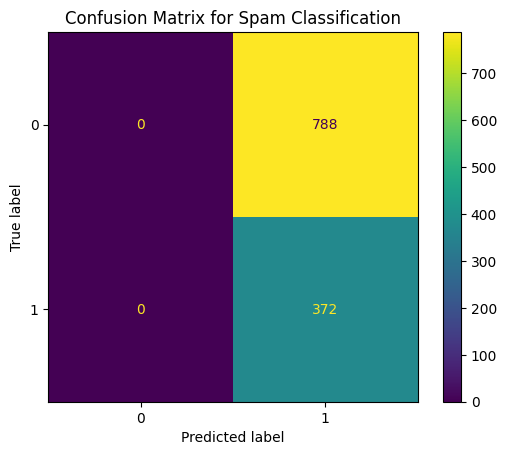

Test Loss: 0.4331, Test Accuracy: 0.3207, F1: 0.4856 (thresh 0)
Reasonable thresholds:


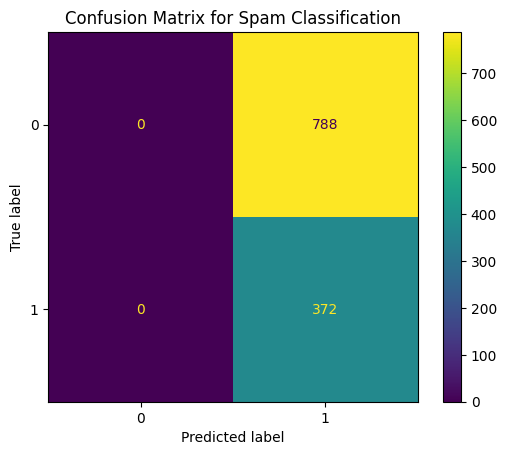

Test Loss: 0.4331, Test Accuracy: 0.3207, F1: 0.4856 (thresh 0.00)


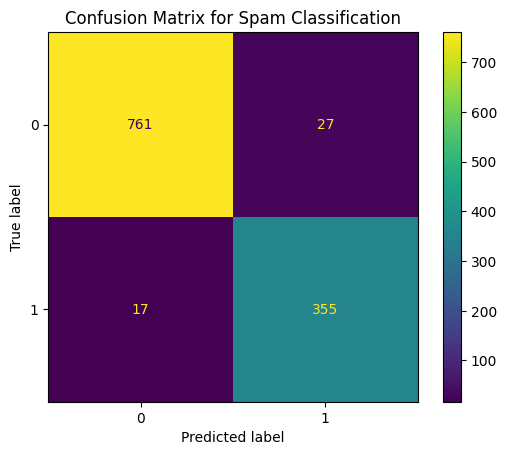

Test Loss: 0.4331, Test Accuracy: 0.9621, F1: 0.9416 (thresh 0.05)


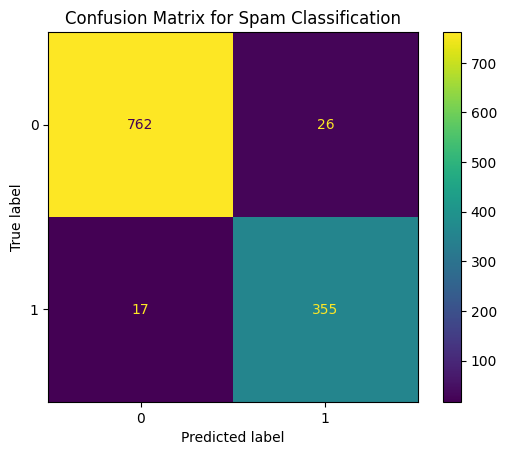

Test Loss: 0.4331, Test Accuracy: 0.9629, F1: 0.9429 (thresh 0.10)


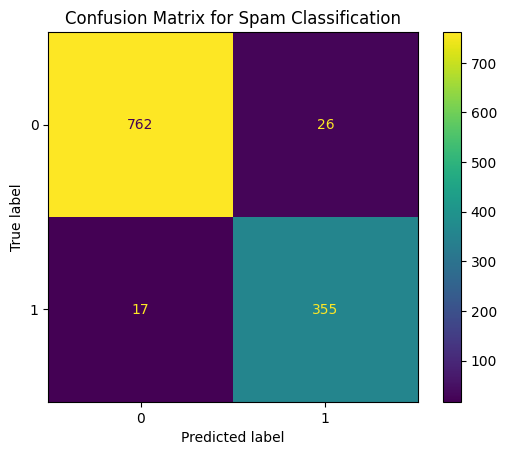

Test Loss: 0.4331, Test Accuracy: 0.9629, F1: 0.9429 (thresh 0.15)


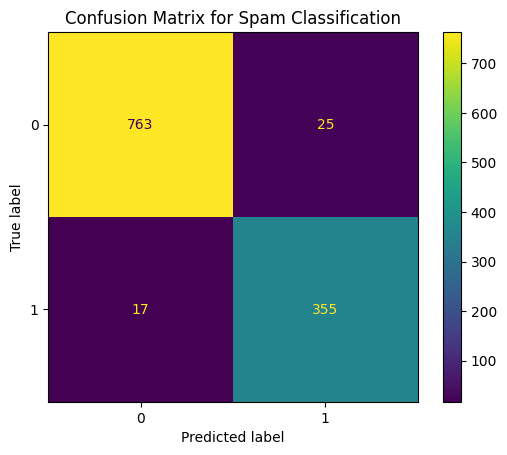

Test Loss: 0.4331, Test Accuracy: 0.9638, F1: 0.9441 (thresh 0.20)


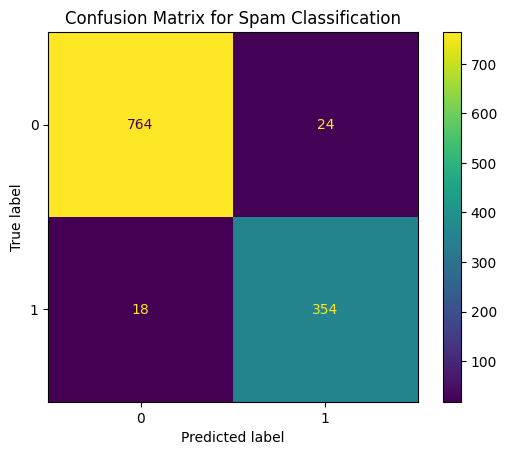

Test Loss: 0.4331, Test Accuracy: 0.9638, F1: 0.9440 (thresh 0.25)


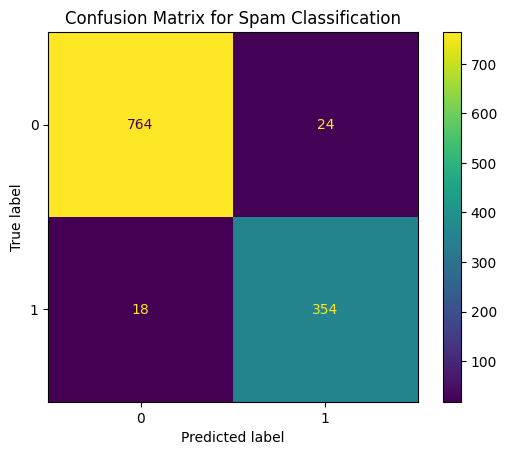

Test Loss: 0.4331, Test Accuracy: 0.9638, F1: 0.9440 (thresh 0.30)


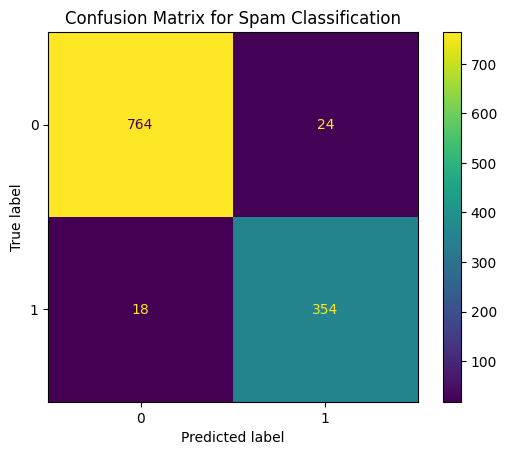

Test Loss: 0.4331, Test Accuracy: 0.9638, F1: 0.9440 (thresh 0.35)


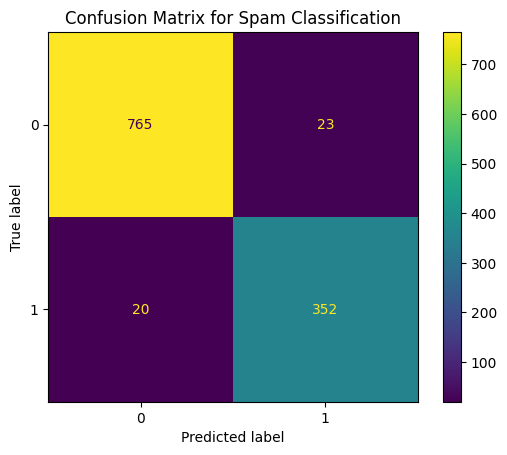

Test Loss: 0.4331, Test Accuracy: 0.9629, F1: 0.9424 (thresh 0.40)


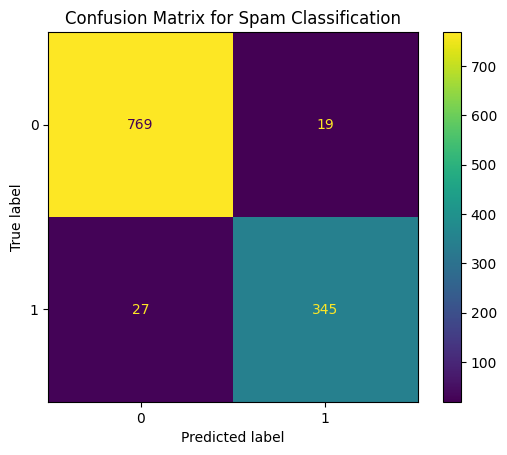

Test Loss: 0.4331, Test Accuracy: 0.9603, F1: 0.9375 (thresh 0.45)


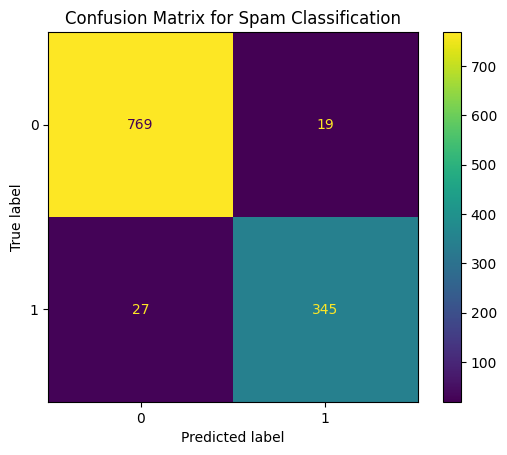

Test Loss: 0.4331, Test Accuracy: 0.9603, F1: 0.9375 (thresh 0.50)


Test Loss: 0.4331, Test Accuracy: 0.9612, F1: 0.9388 (thresh 0.55)


Test Loss: 0.4331, Test Accuracy: 0.9612, F1: 0.9388 (thresh 0.60)


Test Loss: 0.4331, Test Accuracy: 0.9612, F1: 0.9388 (thresh 0.65)


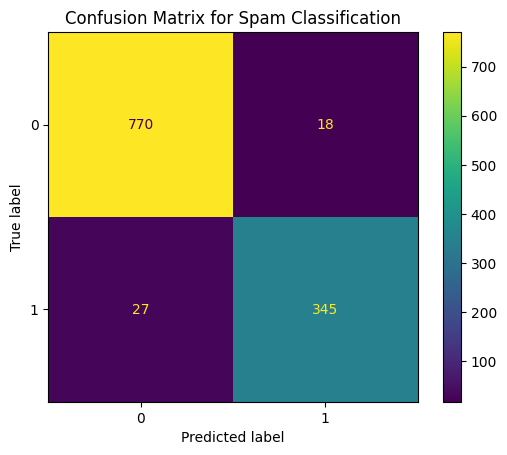

Test Loss: 0.4331, Test Accuracy: 0.9612, F1: 0.9388 (thresh 0.70)


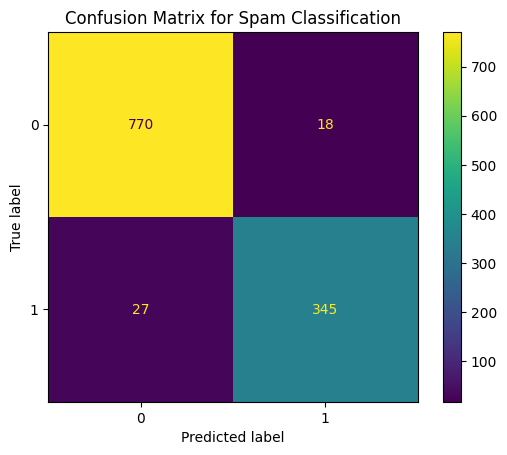

Test Loss: 0.4331, Test Accuracy: 0.9612, F1: 0.9388 (thresh 0.75)


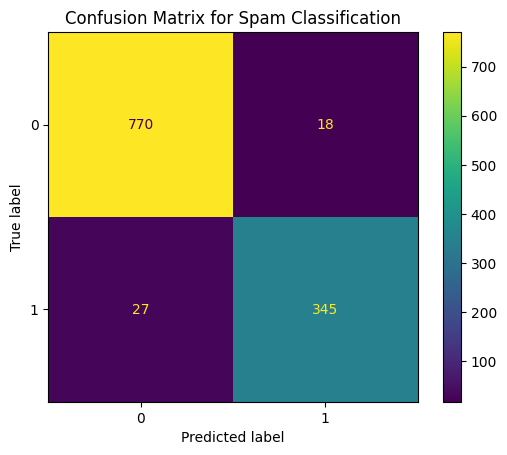

Test Loss: 0.4331, Test Accuracy: 0.9612, F1: 0.9388 (thresh 0.80)


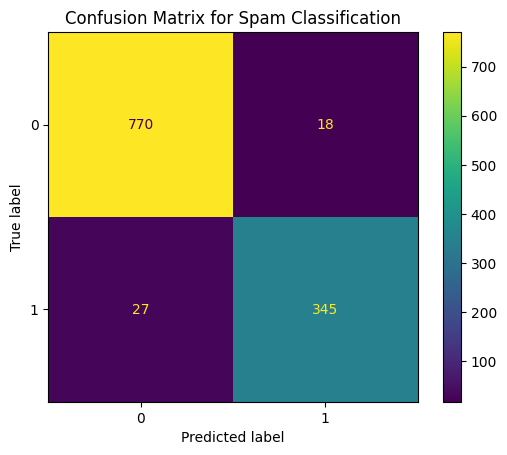

Test Loss: 0.4331, Test Accuracy: 0.9612, F1: 0.9388 (thresh 0.85)


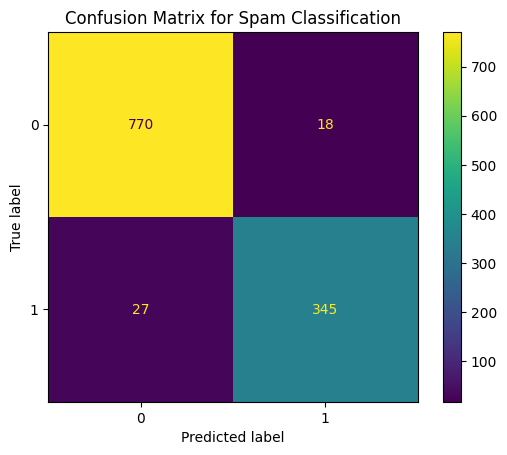

Test Loss: 0.4331, Test Accuracy: 0.9612, F1: 0.9388 (thresh 0.90)


Test Loss: 0.4331, Test Accuracy: 0.9612, F1: 0.9386 (thresh 0.95)


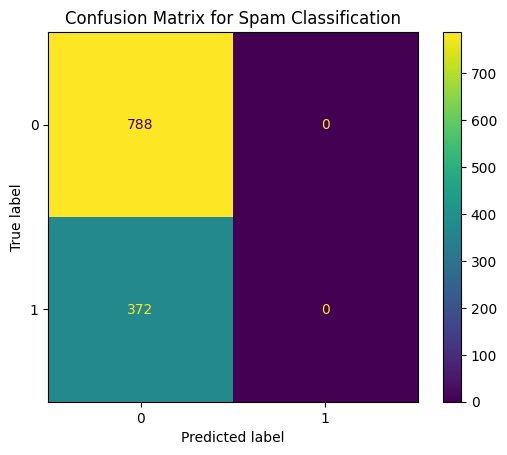

Test Loss: 0.4331, Test Accuracy: 0.6793, F1: 0.0000 (thresh 1.00)


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, test_data, criterion, threshold):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_data:
            inputs, labels, attn_masks = batch  
            inputs = inputs.to(device)
            labels = labels.to(device)
            attn_masks = attn_masks.to(device)

            outputs = model(inputs, attn_masks)  
            loss = criterion(outputs.squeeze(), labels.float())
            total_loss += loss.item()
            preds = torch.sigmoid(outputs.squeeze())
            preds = (preds > threshold).long()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_data)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    fscore = f1_score(np.array(all_labels), np.array(all_preds))
    cm = confusion_matrix(all_labels, all_preds)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    cm_display.plot()
    plt.title("Confusion Matrix for Spam Classification")
    plt.show()

    return avg_loss, accuracy, fscore


print("Edge cases:")
test_loss, test_accuracy, test_fscore = evaluate_model(model, test_data, criterion, 1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1: {test_fscore:.4f} (thresh 1)")
test_loss, test_accuracy, test_fscore = evaluate_model(model, test_data, criterion, 0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1: {test_fscore:.4f} (thresh 0)")

print("Reasonable thresholds:")
for threshold in np.linspace(0, 1, 21):
    test_loss, test_accuracy, test_fscore = evaluate_model(model, test_data, criterion, threshold)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1: {test_fscore:.4f} (thresh {threshold:.2f})")

### Testing Scripts

## Analysis
Possible Tests:
- Standard Log Reg
  - Sklearn that has the countvectorizer
  - take in lists of words bag of words
    - bag of words is document by vocab size where each document has a count of the times each word shows up. No sequence info but maybe helpful for logsitistic because featuers are words instead of positions.
- Naive Bayes
- Confusion Matrices
  - f1 score per class because its a per class basis

Take different coins to see which visualy makes more sense

Possible other ablations:
- Few more?
- Already ablated the transformer
- try different embedings?
- Take out both
- Encoder only vs Decoder
- Try encoder with different poolings

testing other coins:
- Check individual coin classifications:
  - ETH split between scam vs nonscam

New Stuff added by Alex W (3/3/25)
- Max pooling ablation test
- ROC-AUC for masked/nonmasked
- False neg/pos examples for masked/nonmasked